![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "CE-Brazil"
infer_parameters_from_data = True
results_suffix = ".ce-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,452,42,7861,492,9132078.0,NaN,117915,NaN
2020-05-01,139,47,8000,539,9132078.0,NaN,120000,NaN
2020-05-02,309,99,8309,638,9132078.0,NaN,124635,NaN
2020-05-03,70,39,8379,677,9132078.0,NaN,125685,NaN
2020-05-04,0,0,8379,677,9132078.0,NaN,125685,NaN


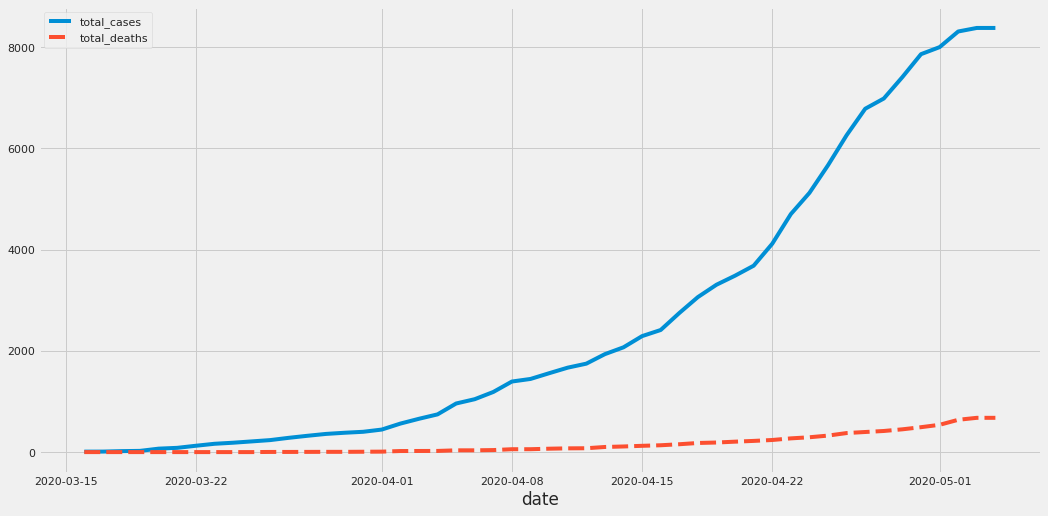

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

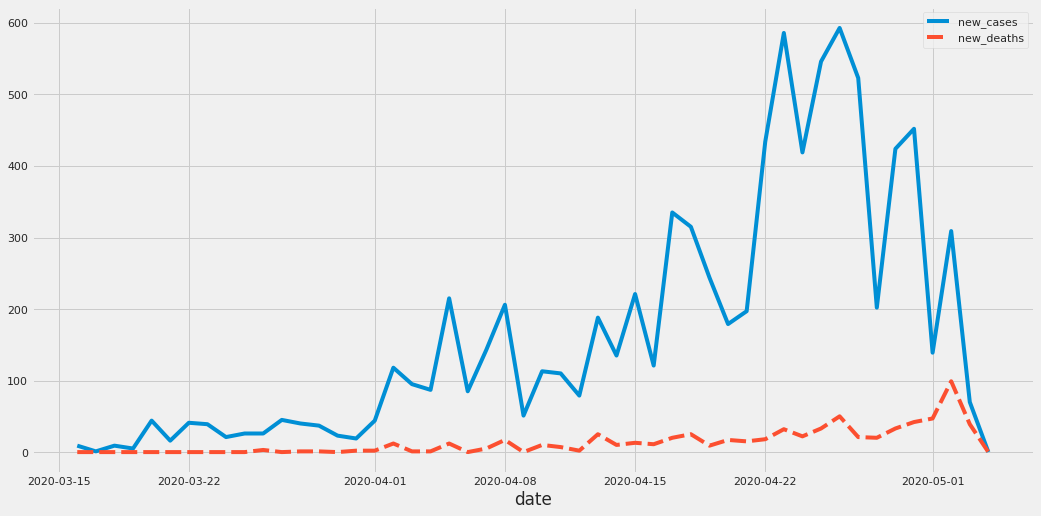

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-03-20 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-03-20 00:00:00, population_size=9132078.0, initially_infected=1020.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-20,9.131058e+06,1020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1020.000000,1020.000000
2020-03-21,9.131058e+06,102.000000,0.000000,918.000000,918.000000,0.000000,0.000000,1020.000000,1020.000000
2020-03-22,9.130324e+06,744.517972,734.317972,734.400000,91.800000,275.400000,275.400000,1478.917972,1754.317972
2020-03-23,9.129736e+06,661.858932,587.407134,1184.146175,670.066175,495.720000,220.320000,1846.005106,2341.725106
2020-03-24,9.128789e+06,1013.259914,947.074021,1424.575361,595.673038,850.963852,355.243852,2437.835274,3288.799127


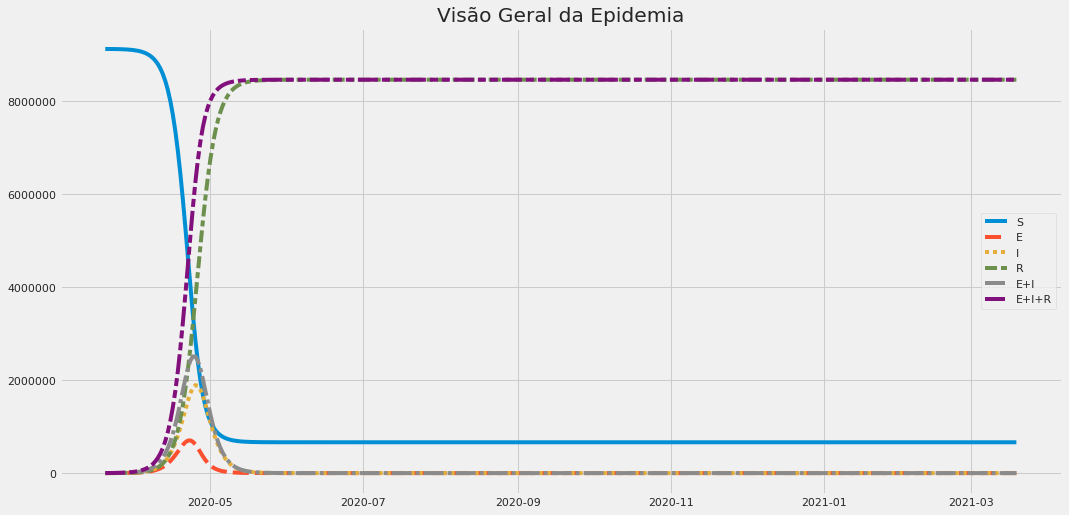

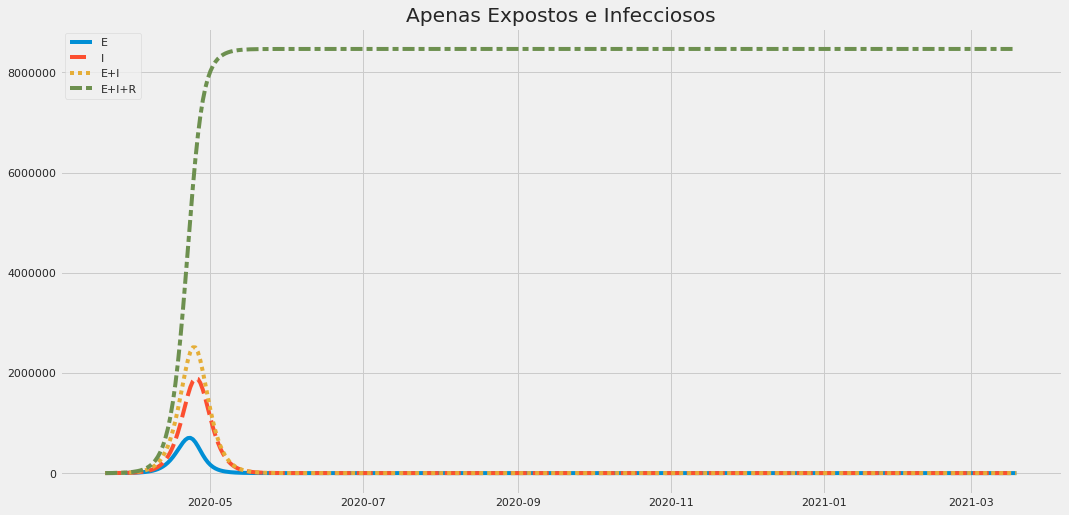

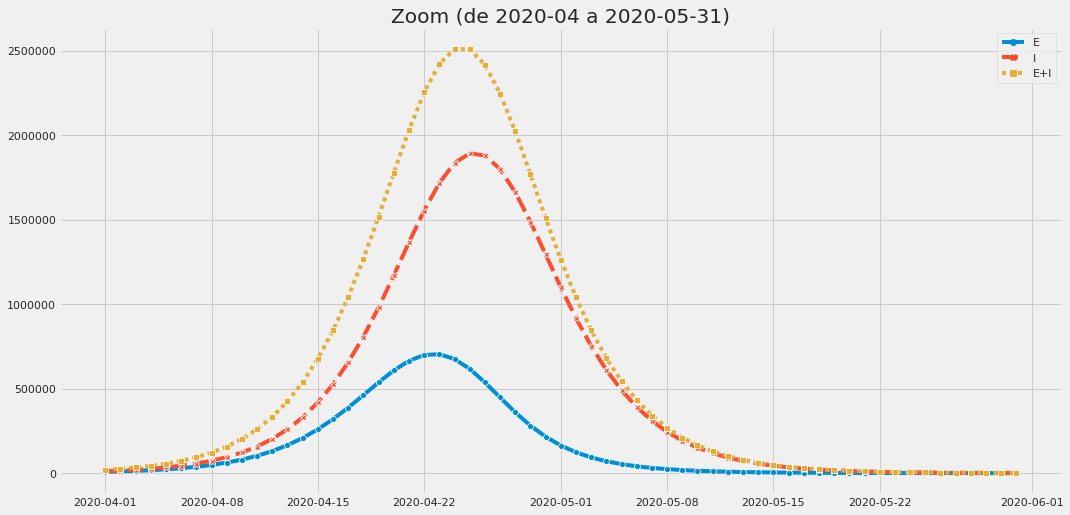

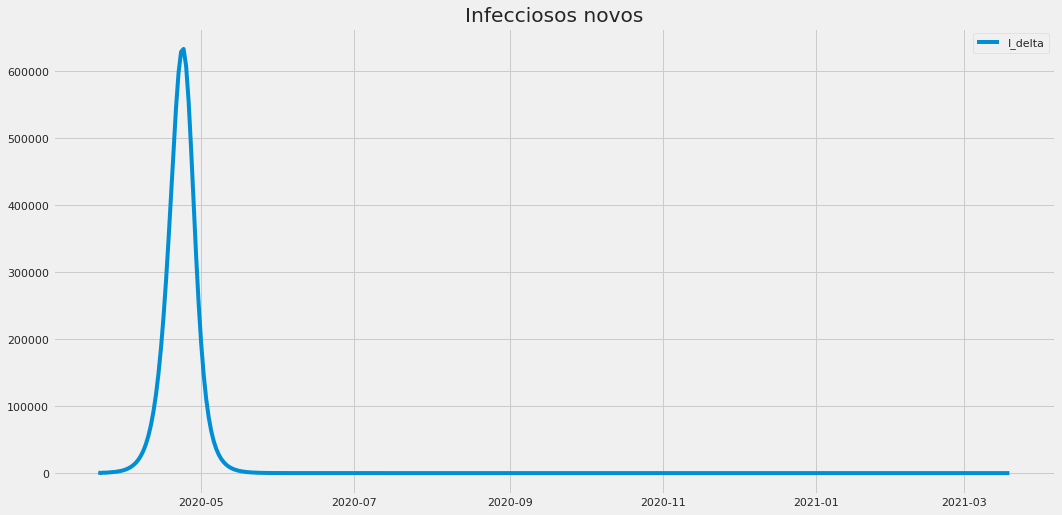

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

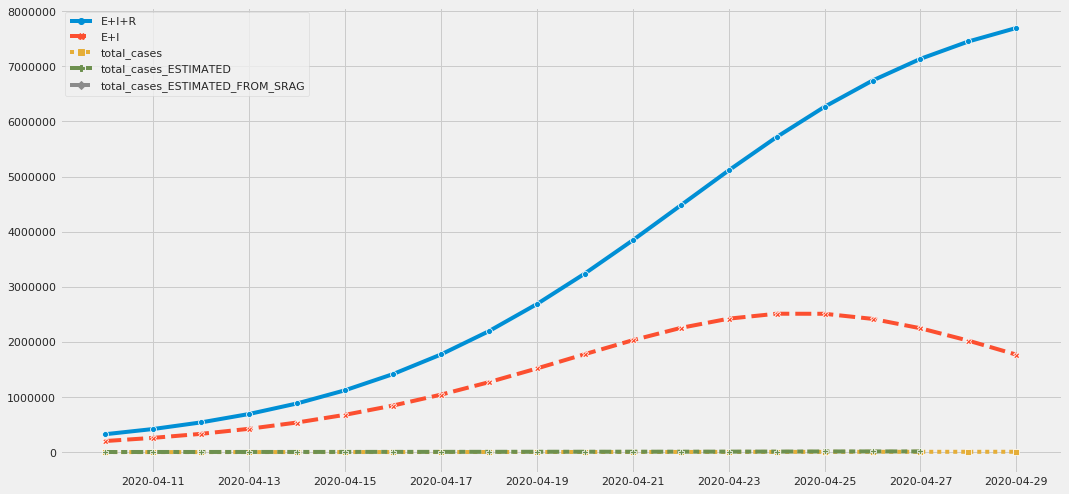

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-20,9.131058e+06,1020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1020.000000,1020.000000
2020-03-21,9.131058e+06,0.000000,0.000000,1020.000000,1020.000000,0.000000,0.000000,1020.000000,1020.000000
2020-03-22,9.130140e+06,917.897465,917.897465,612.000000,0.000000,408.000000,408.000000,1529.897465,1937.897465
2020-03-23,9.129589e+06,550.683116,550.683116,1285.097465,917.897465,652.800000,244.800000,1835.780581,2488.580581
2020-03-24,9.128433e+06,1156.272537,1156.272537,1321.741595,550.683116,1166.838986,514.038986,2478.014132,3644.853118


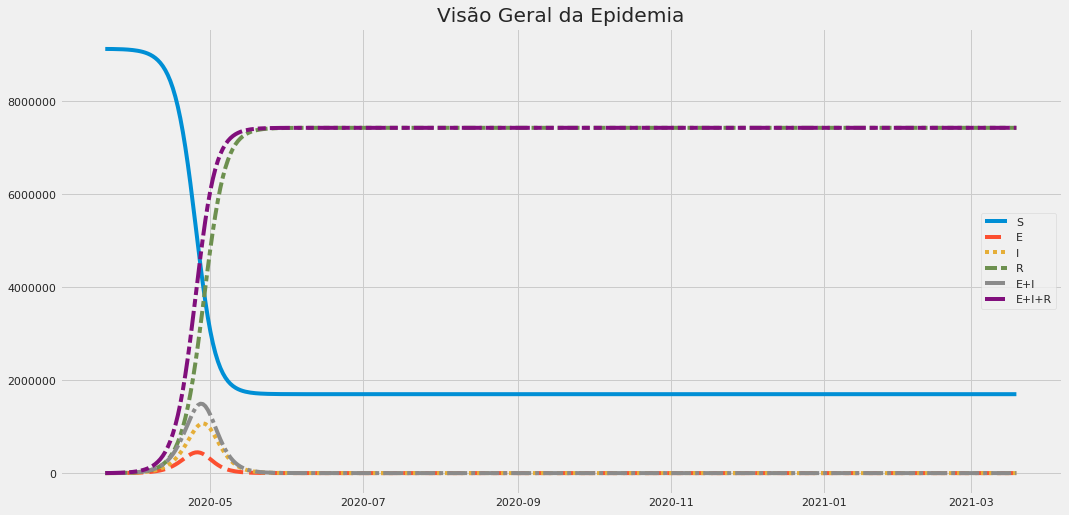

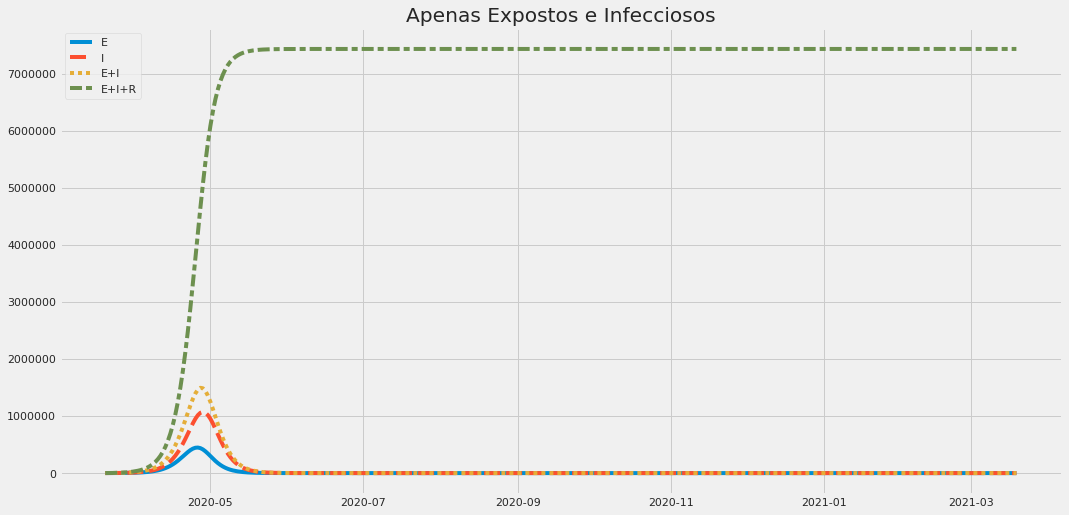

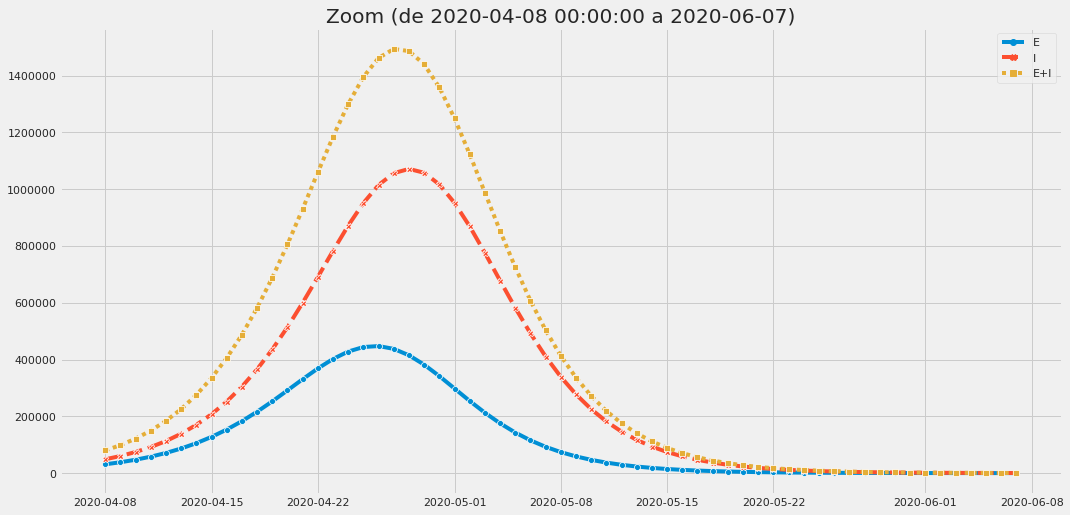

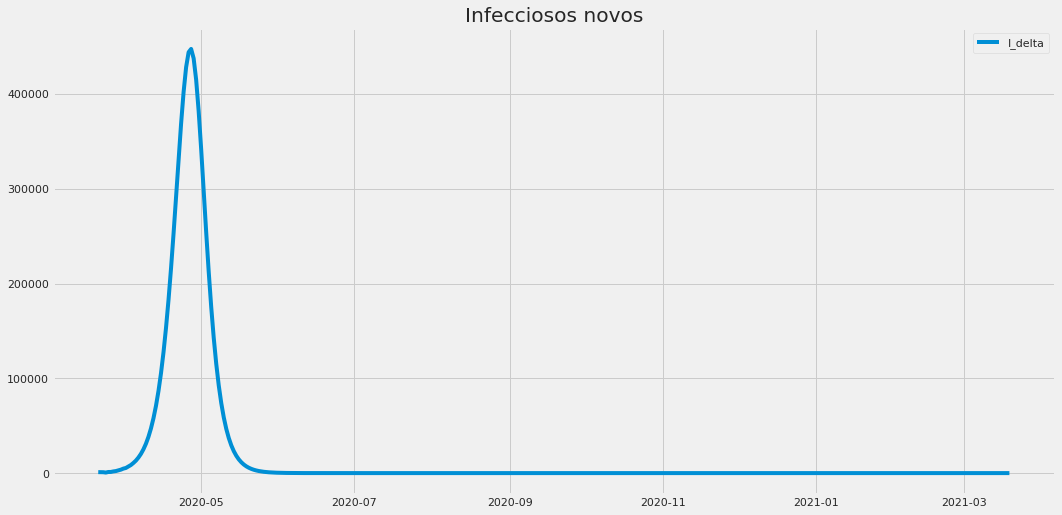

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

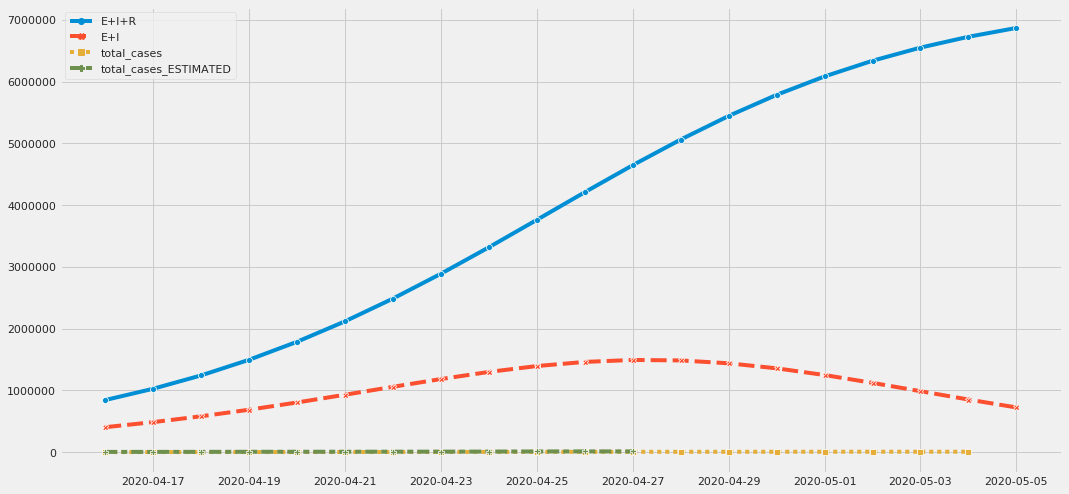

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|▏         | 13/1000 [00:00<00:08, 121.01trial/s, best loss: 632.4159481734895]

  2%|▎         | 25/1000 [00:00<00:08, 116.95trial/s, best loss: 577.6175439296659]

  3%|▎         | 33/1000 [00:00<00:09, 99.65trial/s, best loss: 577.6175439296659] 

  4%|▍         | 42/1000 [00:00<00:10, 95.11trial/s, best loss: 577.6175439296659]

  5%|▌         | 51/1000 [00:00<00:10, 93.19trial/s, best loss: 501.48070565358006]

  6%|▌         | 60/1000 [00:00<00:10, 90.28trial/s, best loss: 425.38625483602056]

  7%|▋         | 69/1000 [00:00<00:10, 87.34trial/s, best loss: 307.3588670390957] 

  8%|▊         | 78/1000 [00:00<00:10, 87.93trial/s, best loss: 288.8812664297549]

  9%|▊         | 87/1000 [00:00<00:10, 85.39trial/s, best loss: 288.8812664297549]

 10%|▉         | 96/1000 [00:01<00:10, 85.70trial/s, best loss: 288.8812664297549]

 10%|█         | 105/1000 [00:01<00:10, 85.70trial/s, best loss: 288.8812664297549]

 11%|█▏        | 114/1000 [00:01<00:10, 84.18trial/s, best loss: 288.8812664297549]

 12%|█▏        | 123/1000 [00:01<00:14, 59.08trial/s, best loss: 288.8812664297549]

 13%|█▎        | 131/1000 [00:01<00:13, 63.84trial/s, best loss: 288.8812664297549]

 14%|█▍        | 139/1000 [00:01<00:14, 60.88trial/s, best loss: 288.8812664297549]

 15%|█▍        | 148/1000 [00:01<00:12, 66.18trial/s, best loss: 288.8812664297549]

 16%|█▌        | 156/1000 [00:02<00:12, 69.35trial/s, best loss: 288.8812664297549]

 16%|█▋        | 165/1000 [00:02<00:11, 72.69trial/s, best loss: 288.8812664297549]

 17%|█▋        | 173/1000 [00:02<00:11, 69.47trial/s, best loss: 288.8812664297549]

 18%|█▊        | 181/1000 [00:02<00:12, 64.45trial/s, best loss: 288.8812664297549]

 19%|█▉        | 189/1000 [00:02<00:11, 68.16trial/s, best loss: 288.8812664297549]

 20%|█▉        | 197/1000 [00:02<00:11, 70.08trial/s, best loss: 288.8812664297549]

 20%|██        | 205/1000 [00:02<00:10, 72.78trial/s, best loss: 288.8812664297549]

 21%|██▏       | 214/1000 [00:02<00:10, 74.07trial/s, best loss: 288.8812664297549]

 22%|██▏       | 222/1000 [00:02<00:10, 74.34trial/s, best loss: 288.8812664297549]

 23%|██▎       | 230/1000 [00:03<00:10, 72.98trial/s, best loss: 288.8812664297549]

 24%|██▍       | 238/1000 [00:03<00:10, 74.37trial/s, best loss: 288.8812664297549]

 25%|██▍       | 246/1000 [00:03<00:09, 75.82trial/s, best loss: 288.8812664297549]

 25%|██▌       | 254/1000 [00:03<00:10, 72.01trial/s, best loss: 288.8812664297549]

 26%|██▌       | 262/1000 [00:03<00:10, 71.58trial/s, best loss: 288.8812664297549]

 27%|██▋       | 270/1000 [00:03<00:10, 71.42trial/s, best loss: 288.8812664297549]

 28%|██▊       | 278/1000 [00:03<00:10, 72.05trial/s, best loss: 288.8812664297549]

 29%|██▊       | 286/1000 [00:03<00:09, 73.05trial/s, best loss: 288.8812664297549]

 29%|██▉       | 294/1000 [00:03<00:09, 71.74trial/s, best loss: 288.8812664297549]

 30%|███       | 302/1000 [00:04<00:09, 70.38trial/s, best loss: 288.8812664297549]

 31%|███       | 310/1000 [00:04<00:09, 71.49trial/s, best loss: 276.4072204337474]

 32%|███▏      | 318/1000 [00:04<00:09, 72.68trial/s, best loss: 276.4072204337474]

 33%|███▎      | 326/1000 [00:04<00:09, 68.38trial/s, best loss: 276.4072204337474]

 33%|███▎      | 333/1000 [00:04<00:10, 62.10trial/s, best loss: 276.4072204337474]

 34%|███▍      | 341/1000 [00:04<00:10, 64.57trial/s, best loss: 276.4072204337474]

 35%|███▍      | 349/1000 [00:04<00:09, 66.51trial/s, best loss: 276.4072204337474]

 36%|███▌      | 356/1000 [00:04<00:09, 67.15trial/s, best loss: 276.4072204337474]

 36%|███▋      | 363/1000 [00:04<00:09, 67.45trial/s, best loss: 276.4072204337474]

 37%|███▋      | 370/1000 [00:05<00:09, 67.20trial/s, best loss: 276.4072204337474]

 38%|███▊      | 377/1000 [00:05<00:09, 67.50trial/s, best loss: 276.4072204337474]

 38%|███▊      | 384/1000 [00:05<00:10, 57.15trial/s, best loss: 276.4072204337474]

 39%|███▉      | 391/1000 [00:05<00:10, 59.33trial/s, best loss: 276.4072204337474]

 40%|███▉      | 398/1000 [00:05<00:09, 60.93trial/s, best loss: 276.4072204337474]

 40%|████      | 405/1000 [00:05<00:09, 61.88trial/s, best loss: 276.4072204337474]

 41%|████      | 412/1000 [00:05<00:09, 62.81trial/s, best loss: 276.4072204337474]

 42%|████▏     | 419/1000 [00:05<00:09, 64.04trial/s, best loss: 276.4072204337474]

 43%|████▎     | 426/1000 [00:05<00:08, 64.46trial/s, best loss: 276.4072204337474]

 43%|████▎     | 433/1000 [00:06<00:08, 64.56trial/s, best loss: 276.4072204337474]

 44%|████▍     | 440/1000 [00:06<00:08, 64.98trial/s, best loss: 276.4072204337474]

 45%|████▍     | 447/1000 [00:06<00:08, 64.05trial/s, best loss: 276.4072204337474]

 45%|████▌     | 454/1000 [00:06<00:08, 63.76trial/s, best loss: 276.4072204337474]

 46%|████▌     | 461/1000 [00:06<00:08, 63.97trial/s, best loss: 276.4072204337474]

 47%|████▋     | 468/1000 [00:06<00:08, 63.13trial/s, best loss: 276.4072204337474]

 48%|████▊     | 475/1000 [00:06<00:08, 63.59trial/s, best loss: 276.4072204337474]

 48%|████▊     | 482/1000 [00:06<00:08, 63.61trial/s, best loss: 276.4072204337474]

 49%|████▉     | 489/1000 [00:06<00:08, 63.78trial/s, best loss: 276.4072204337474]

 50%|████▉     | 496/1000 [00:07<00:08, 62.61trial/s, best loss: 276.4072204337474]

 50%|█████     | 503/1000 [00:07<00:07, 62.25trial/s, best loss: 276.4072204337474]

 51%|█████     | 510/1000 [00:07<00:08, 58.79trial/s, best loss: 276.4072204337474]

 52%|█████▏    | 517/1000 [00:07<00:08, 59.90trial/s, best loss: 276.4072204337474]

 52%|█████▏    | 524/1000 [00:07<00:07, 60.33trial/s, best loss: 276.4072204337474]

 53%|█████▎    | 531/1000 [00:07<00:07, 59.95trial/s, best loss: 276.4072204337474]

 54%|█████▍    | 538/1000 [00:07<00:07, 60.31trial/s, best loss: 276.4072204337474]

 55%|█████▍    | 545/1000 [00:07<00:07, 60.48trial/s, best loss: 276.4072204337474]

 55%|█████▌    | 552/1000 [00:08<00:07, 59.98trial/s, best loss: 276.4072204337474]

 56%|█████▌    | 559/1000 [00:08<00:07, 59.99trial/s, best loss: 276.4072204337474]

 57%|█████▋    | 566/1000 [00:08<00:07, 59.96trial/s, best loss: 276.4072204337474]

 57%|█████▋    | 573/1000 [00:08<00:07, 57.81trial/s, best loss: 276.4072204337474]

 58%|█████▊    | 579/1000 [00:08<00:07, 57.25trial/s, best loss: 276.4072204337474]

 58%|█████▊    | 585/1000 [00:08<00:07, 57.39trial/s, best loss: 276.4072204337474]

 59%|█████▉    | 591/1000 [00:08<00:07, 57.91trial/s, best loss: 276.4072204337474]

 60%|█████▉    | 597/1000 [00:08<00:07, 56.01trial/s, best loss: 276.4072204337474]

 60%|██████    | 603/1000 [00:08<00:06, 57.10trial/s, best loss: 276.4072204337474]

 61%|██████    | 609/1000 [00:09<00:06, 56.90trial/s, best loss: 276.4072204337474]

 62%|██████▏   | 615/1000 [00:09<00:06, 57.28trial/s, best loss: 276.4072204337474]

 62%|██████▏   | 621/1000 [00:09<00:06, 57.48trial/s, best loss: 276.4072204337474]

 63%|██████▎   | 627/1000 [00:09<00:06, 55.61trial/s, best loss: 276.4072204337474]

 63%|██████▎   | 633/1000 [00:09<00:06, 56.08trial/s, best loss: 276.4072204337474]

 64%|██████▍   | 639/1000 [00:09<00:06, 56.35trial/s, best loss: 276.4072204337474]

 64%|██████▍   | 645/1000 [00:09<00:06, 56.33trial/s, best loss: 276.4072204337474]

 65%|██████▌   | 651/1000 [00:09<00:06, 56.74trial/s, best loss: 276.4072204337474]

 66%|██████▌   | 657/1000 [00:09<00:06, 56.92trial/s, best loss: 276.4072204337474]

 66%|██████▋   | 663/1000 [00:09<00:05, 57.11trial/s, best loss: 276.4072204337474]

 67%|██████▋   | 669/1000 [00:10<00:05, 57.05trial/s, best loss: 276.4072204337474]

 68%|██████▊   | 675/1000 [00:10<00:05, 57.06trial/s, best loss: 276.4072204337474]

 68%|██████▊   | 681/1000 [00:10<00:05, 55.00trial/s, best loss: 276.4072204337474]

 69%|██████▊   | 687/1000 [00:10<00:05, 53.33trial/s, best loss: 276.4072204337474]

 69%|██████▉   | 693/1000 [00:10<00:05, 53.75trial/s, best loss: 276.4072204337474]

 70%|██████▉   | 699/1000 [00:10<00:05, 52.84trial/s, best loss: 276.4072204337474]

 70%|███████   | 705/1000 [00:10<00:05, 53.54trial/s, best loss: 276.4072204337474]

 71%|███████   | 711/1000 [00:10<00:05, 53.91trial/s, best loss: 276.4072204337474]

 72%|███████▏  | 717/1000 [00:10<00:05, 54.50trial/s, best loss: 276.4072204337474]

 72%|███████▏  | 723/1000 [00:11<00:05, 48.94trial/s, best loss: 276.4072204337474]

 73%|███████▎  | 729/1000 [00:11<00:05, 50.75trial/s, best loss: 276.4072204337474]

 74%|███████▎  | 735/1000 [00:11<00:05, 49.34trial/s, best loss: 276.4072204337474]

 74%|███████▍  | 741/1000 [00:11<00:05, 50.48trial/s, best loss: 276.4072204337474]

 75%|███████▍  | 747/1000 [00:11<00:04, 51.24trial/s, best loss: 276.4072204337474]

 75%|███████▌  | 753/1000 [00:11<00:05, 44.56trial/s, best loss: 276.4072204337474]

 76%|███████▌  | 759/1000 [00:11<00:05, 46.53trial/s, best loss: 276.4072204337474]

 76%|███████▋  | 765/1000 [00:11<00:04, 48.39trial/s, best loss: 276.4072204337474]

 77%|███████▋  | 771/1000 [00:12<00:04, 49.57trial/s, best loss: 276.4072204337474]

 78%|███████▊  | 777/1000 [00:12<00:04, 50.52trial/s, best loss: 276.4072204337474]

 78%|███████▊  | 783/1000 [00:12<00:04, 50.30trial/s, best loss: 276.4072204337474]

 79%|███████▉  | 789/1000 [00:12<00:04, 50.83trial/s, best loss: 276.4072204337474]

 80%|███████▉  | 795/1000 [00:12<00:03, 51.30trial/s, best loss: 276.4072204337474]

 80%|████████  | 801/1000 [00:12<00:03, 51.06trial/s, best loss: 276.4072204337474]

 81%|████████  | 807/1000 [00:12<00:03, 51.40trial/s, best loss: 276.4072204337474]

 81%|████████▏ | 813/1000 [00:12<00:03, 51.61trial/s, best loss: 276.4072204337474]

 82%|████████▏ | 819/1000 [00:13<00:03, 51.77trial/s, best loss: 276.4072204337474]

 82%|████████▎ | 825/1000 [00:13<00:03, 51.77trial/s, best loss: 276.4072204337474]

 83%|████████▎ | 831/1000 [00:13<00:03, 51.90trial/s, best loss: 275.6880404051116]

 84%|████████▎ | 837/1000 [00:13<00:03, 50.95trial/s, best loss: 275.6880404051116]

 84%|████████▍ | 843/1000 [00:13<00:03, 50.83trial/s, best loss: 275.6880404051116]

 85%|████████▍ | 849/1000 [00:13<00:02, 50.80trial/s, best loss: 275.6880404051116]

 86%|████████▌ | 855/1000 [00:13<00:02, 50.90trial/s, best loss: 275.6880404051116]

 86%|████████▌ | 861/1000 [00:13<00:02, 50.61trial/s, best loss: 275.6880404051116]

 87%|████████▋ | 867/1000 [00:13<00:02, 50.64trial/s, best loss: 275.6880404051116]

 87%|████████▋ | 873/1000 [00:14<00:02, 49.80trial/s, best loss: 275.6880404051116]

 88%|████████▊ | 878/1000 [00:14<00:02, 49.75trial/s, best loss: 275.6880404051116]

 88%|████████▊ | 883/1000 [00:14<00:02, 48.83trial/s, best loss: 275.6880404051116]

 89%|████████▉ | 888/1000 [00:14<00:02, 48.39trial/s, best loss: 275.6880404051116]

 89%|████████▉ | 894/1000 [00:14<00:02, 48.95trial/s, best loss: 275.6880404051116]

 90%|████████▉ | 899/1000 [00:14<00:02, 43.49trial/s, best loss: 275.6880404051116]

 90%|█████████ | 905/1000 [00:14<00:02, 45.41trial/s, best loss: 275.6880404051116]

 91%|█████████ | 911/1000 [00:14<00:01, 46.80trial/s, best loss: 275.6880404051116]

 92%|█████████▏| 916/1000 [00:15<00:01, 47.58trial/s, best loss: 275.6880404051116]

 92%|█████████▏| 921/1000 [00:15<00:01, 48.22trial/s, best loss: 275.6880404051116]

 93%|█████████▎| 926/1000 [00:15<00:01, 48.48trial/s, best loss: 275.6880404051116]

 93%|█████████▎| 931/1000 [00:15<00:01, 47.75trial/s, best loss: 275.6880404051116]

 94%|█████████▎| 936/1000 [00:15<00:01, 47.97trial/s, best loss: 275.6880404051116]

 94%|█████████▍| 941/1000 [00:15<00:01, 48.30trial/s, best loss: 275.6880404051116]

 95%|█████████▍| 946/1000 [00:15<00:01, 48.13trial/s, best loss: 275.6880404051116]

 95%|█████████▌| 951/1000 [00:15<00:01, 48.55trial/s, best loss: 275.6880404051116]

 96%|█████████▌| 956/1000 [00:15<00:00, 48.57trial/s, best loss: 275.6880404051116]

 96%|█████████▌| 961/1000 [00:15<00:00, 48.71trial/s, best loss: 275.6880404051116]

 97%|█████████▋| 966/1000 [00:16<00:00, 48.74trial/s, best loss: 275.6880404051116]

 97%|█████████▋| 971/1000 [00:16<00:00, 48.62trial/s, best loss: 275.6880404051116]

 98%|█████████▊| 976/1000 [00:16<00:00, 48.87trial/s, best loss: 275.6880404051116]

 98%|█████████▊| 981/1000 [00:16<00:00, 46.84trial/s, best loss: 275.6880404051116]

 99%|█████████▊| 986/1000 [00:16<00:00, 47.17trial/s, best loss: 275.6880404051116]

 99%|█████████▉| 991/1000 [00:16<00:00, 47.39trial/s, best loss: 275.6880404051116]

100%|█████████▉| 996/1000 [00:16<00:00, 47.50trial/s, best loss: 275.6880404051116]

100%|██████████| 1000/1000 [00:16<00:00, 59.53trial/s, best loss: 275.6880404051116]


Best parameters found: {'alpha': 0.9909177139640984, 'beta': 0.6961294943322196, 'gamma': 0.6003389105767187}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-20,9.131058e+06,1020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1020.000000,1020.000000
2020-03-21,9.131058e+06,9.263932,0.000000,1010.736068,1010.736068,0.000000,0.000000,1020.000000,1020.000000
2020-03-22,9.130354e+06,703.608737,703.524600,413.131672,9.179794,606.784190,606.784190,1116.740410,1723.524600
2020-03-23,9.130067e+06,293.929240,287.538864,862.331016,697.218362,854.803208,248.019018,1156.260255,2011.063463
2020-03-24,9.129467e+06,602.831407,600.161857,635.899843,291.259690,1372.494071,517.690863,1238.731250,2611.225321


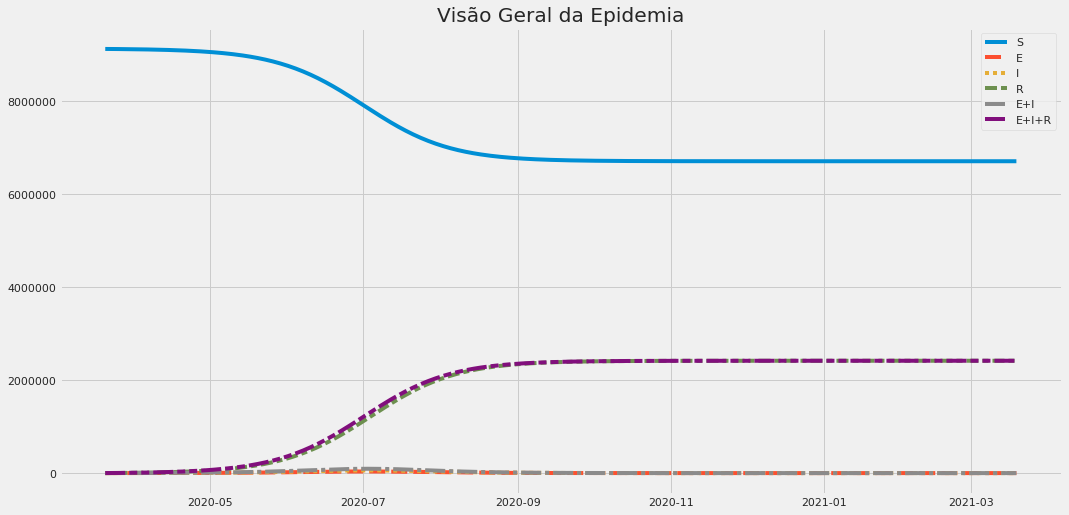

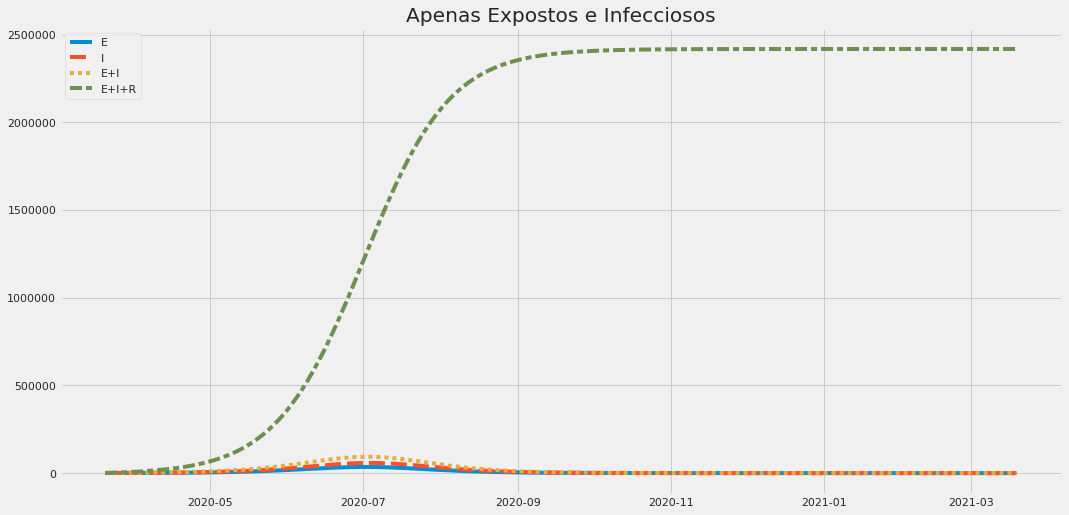

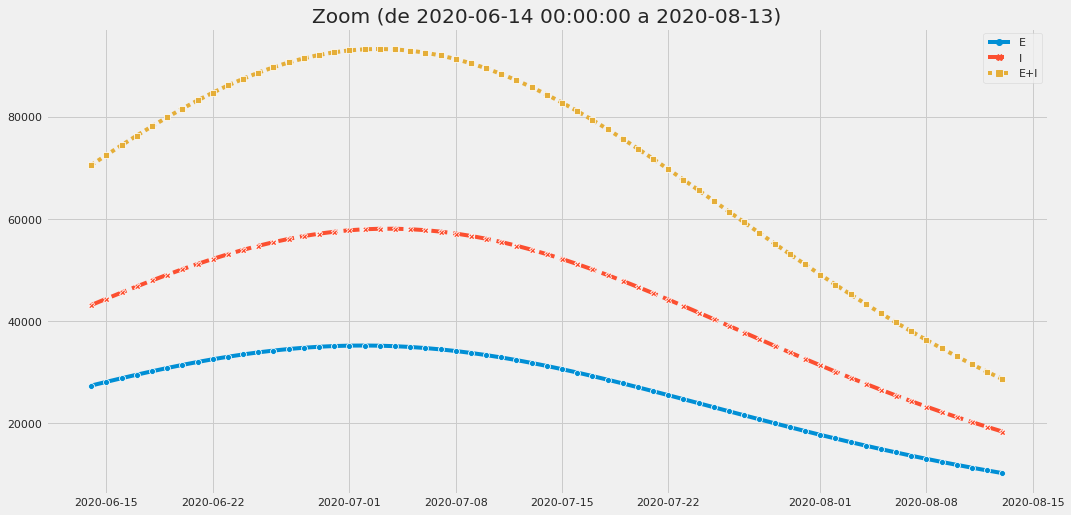

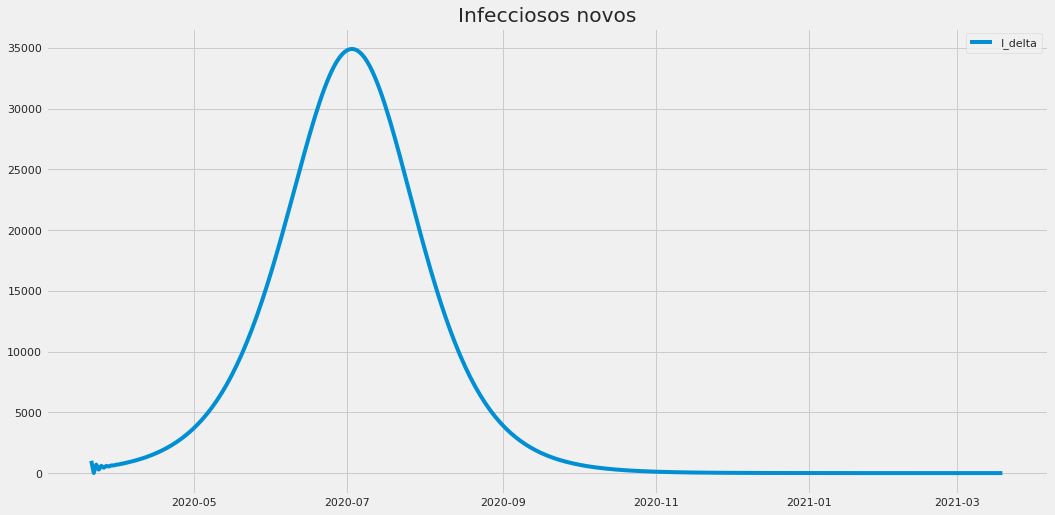

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,452,42,7861,492,9132078.0,NaN,117915,NaN
2020-05-01,139,47,8000,539,9132078.0,NaN,120000,NaN
2020-05-02,309,99,8309,638,9132078.0,NaN,124635,NaN
2020-05-03,70,39,8379,677,9132078.0,NaN,125685,NaN
2020-05-04,0,0,8379,677,9132078.0,NaN,125685,NaN


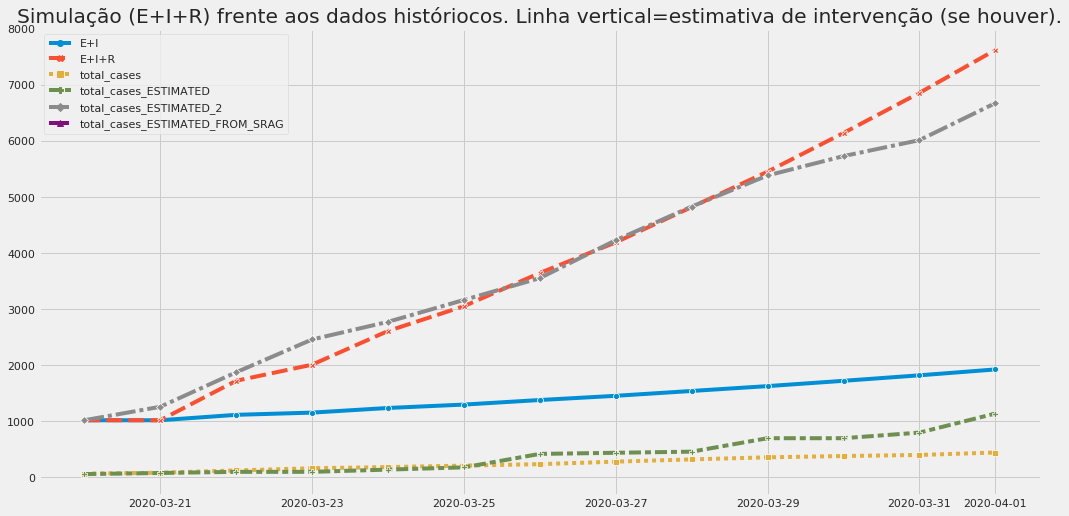

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:32, 90.64trial/s, best loss: 17957.20561080097]

  1%|          | 20/3000 [00:00<00:32, 90.78trial/s, best loss: 9033.962573719185]

  1%|          | 26/3000 [00:00<00:40, 73.69trial/s, best loss: 9033.962573719185]

  1%|          | 31/3000 [00:00<00:54, 54.34trial/s, best loss: 9033.962573719185]

  1%|          | 37/3000 [00:00<00:55, 53.19trial/s, best loss: 9033.962573719185]

  1%|▏         | 42/3000 [00:00<00:57, 51.52trial/s, best loss: 9033.962573719185]

  2%|▏         | 47/3000 [00:00<00:58, 50.79trial/s, best loss: 9033.962573719185]

  2%|▏         | 52/3000 [00:00<00:59, 49.60trial/s, best loss: 9033.962573719185]

  2%|▏         | 57/3000 [00:01<00:59, 49.35trial/s, best loss: 9033.962573719185]

  2%|▏         | 62/3000 [00:01<01:05, 44.96trial/s, best loss: 9033.962573719185]

  2%|▏         | 67/3000 [00:01<01:04, 45.68trial/s, best loss: 9033.962573719185]

  2%|▏         | 72/3000 [00:01<01:03, 46.30trial/s, best loss: 9033.962573719185]

  3%|▎         | 77/3000 [00:01<01:03, 46.20trial/s, best loss: 9033.962573719185]

  3%|▎         | 82/3000 [00:01<01:02, 46.52trial/s, best loss: 9033.962573719185]

  3%|▎         | 87/3000 [00:01<01:02, 46.45trial/s, best loss: 9033.962573719185]

  3%|▎         | 92/3000 [00:01<01:03, 45.94trial/s, best loss: 9033.962573719185]

  3%|▎         | 97/3000 [00:01<01:04, 45.25trial/s, best loss: 9033.962573719185]

  3%|▎         | 102/3000 [00:02<01:24, 34.13trial/s, best loss: 9033.962573719185]

  4%|▎         | 107/3000 [00:02<01:19, 36.60trial/s, best loss: 8954.50812342211] 

  4%|▎         | 112/3000 [00:02<01:14, 38.70trial/s, best loss: 8954.50812342211]

  4%|▍         | 117/3000 [00:02<01:11, 40.15trial/s, best loss: 8954.50812342211]

  4%|▍         | 122/3000 [00:02<01:09, 41.52trial/s, best loss: 8954.50812342211]

  4%|▍         | 127/3000 [00:02<01:07, 42.56trial/s, best loss: 8954.50812342211]

  4%|▍         | 132/3000 [00:02<01:06, 42.81trial/s, best loss: 8954.50812342211]

  5%|▍         | 137/3000 [00:02<01:06, 42.80trial/s, best loss: 8954.50812342211]

  5%|▍         | 142/3000 [00:03<01:07, 42.10trial/s, best loss: 8954.50812342211]

  5%|▍         | 147/3000 [00:03<01:08, 41.69trial/s, best loss: 8954.50812342211]

  5%|▌         | 152/3000 [00:03<01:07, 42.18trial/s, best loss: 8954.50812342211]

  5%|▌         | 157/3000 [00:03<01:11, 39.87trial/s, best loss: 8471.808821421222]

  5%|▌         | 162/3000 [00:03<01:09, 40.73trial/s, best loss: 8471.808821421222]

  6%|▌         | 167/3000 [00:03<01:08, 41.59trial/s, best loss: 6586.308432362059]

  6%|▌         | 172/3000 [00:03<01:07, 42.10trial/s, best loss: 6415.667480735263]

  6%|▌         | 177/3000 [00:03<01:06, 42.29trial/s, best loss: 6415.667480735263]

  6%|▌         | 182/3000 [00:04<01:06, 42.27trial/s, best loss: 6415.667480735263]

  6%|▌         | 187/3000 [00:04<01:09, 40.24trial/s, best loss: 6415.667480735263]

  6%|▋         | 192/3000 [00:04<01:10, 40.07trial/s, best loss: 6415.667480735263]

  7%|▋         | 197/3000 [00:04<01:21, 34.25trial/s, best loss: 6415.667480735263]

  7%|▋         | 202/3000 [00:04<01:17, 36.33trial/s, best loss: 6415.667480735263]

  7%|▋         | 207/3000 [00:04<01:13, 37.91trial/s, best loss: 6415.667480735263]

  7%|▋         | 212/3000 [00:04<01:11, 38.84trial/s, best loss: 6415.667480735263]

  7%|▋         | 217/3000 [00:04<01:10, 39.53trial/s, best loss: 6415.667480735263]

  7%|▋         | 222/3000 [00:05<01:09, 39.87trial/s, best loss: 6415.667480735263]

  8%|▊         | 227/3000 [00:05<01:10, 39.16trial/s, best loss: 6415.667480735263]

  8%|▊         | 231/3000 [00:05<01:10, 39.38trial/s, best loss: 6415.667480735263]

  8%|▊         | 235/3000 [00:05<01:10, 39.49trial/s, best loss: 6415.667480735263]

  8%|▊         | 240/3000 [00:05<01:09, 39.69trial/s, best loss: 6415.667480735263]

  8%|▊         | 245/3000 [00:05<01:09, 39.91trial/s, best loss: 6415.667480735263]

  8%|▊         | 249/3000 [00:05<01:09, 39.74trial/s, best loss: 6415.667480735263]

  8%|▊         | 253/3000 [00:05<01:09, 39.30trial/s, best loss: 6415.667480735263]

  9%|▊         | 257/3000 [00:05<01:10, 39.17trial/s, best loss: 6415.667480735263]

  9%|▊         | 261/3000 [00:06<01:10, 39.05trial/s, best loss: 6415.667480735263]

  9%|▉         | 265/3000 [00:06<01:11, 38.19trial/s, best loss: 6415.667480735263]

  9%|▉         | 269/3000 [00:06<01:11, 38.19trial/s, best loss: 6415.667480735263]

  9%|▉         | 273/3000 [00:06<01:11, 38.07trial/s, best loss: 6415.667480735263]

  9%|▉         | 277/3000 [00:06<01:12, 37.76trial/s, best loss: 6415.667480735263]

  9%|▉         | 281/3000 [00:06<01:11, 38.05trial/s, best loss: 6415.667480735263]

 10%|▉         | 285/3000 [00:06<01:10, 38.24trial/s, best loss: 6415.667480735263]

 10%|▉         | 289/3000 [00:06<01:10, 38.26trial/s, best loss: 6415.667480735263]

 10%|▉         | 293/3000 [00:06<01:11, 38.02trial/s, best loss: 6415.667480735263]

 10%|▉         | 297/3000 [00:07<01:11, 37.81trial/s, best loss: 6415.667480735263]

 10%|█         | 301/3000 [00:07<01:14, 36.41trial/s, best loss: 4723.948701591264]

 10%|█         | 305/3000 [00:07<01:13, 36.85trial/s, best loss: 4723.948701591264]

 10%|█         | 309/3000 [00:07<01:12, 37.12trial/s, best loss: 4723.948701591264]

 10%|█         | 313/3000 [00:07<01:12, 36.90trial/s, best loss: 4198.158591165277]

 11%|█         | 317/3000 [00:07<01:18, 33.98trial/s, best loss: 4198.158591165277]

 11%|█         | 321/3000 [00:07<01:22, 32.41trial/s, best loss: 4198.158591165277]

 11%|█         | 325/3000 [00:07<01:19, 33.50trial/s, best loss: 4198.158591165277]

 11%|█         | 329/3000 [00:07<01:17, 34.59trial/s, best loss: 4198.158591165277]

 11%|█         | 333/3000 [00:08<01:15, 35.13trial/s, best loss: 4198.158591165277]

 11%|█         | 337/3000 [00:08<01:16, 34.78trial/s, best loss: 4198.158591165277]

 11%|█▏        | 341/3000 [00:08<01:16, 34.97trial/s, best loss: 4198.158591165277]

 12%|█▏        | 345/3000 [00:08<01:16, 34.92trial/s, best loss: 4198.158591165277]

 12%|█▏        | 349/3000 [00:08<01:16, 34.44trial/s, best loss: 4198.158591165277]

 12%|█▏        | 353/3000 [00:08<01:18, 33.92trial/s, best loss: 4198.158591165277]

 12%|█▏        | 357/3000 [00:08<01:18, 33.55trial/s, best loss: 4198.158591165277]

 12%|█▏        | 361/3000 [00:08<01:19, 33.01trial/s, best loss: 4198.158591165277]

 12%|█▏        | 365/3000 [00:09<01:29, 29.59trial/s, best loss: 4198.158591165277]

 12%|█▏        | 369/3000 [00:09<01:28, 29.58trial/s, best loss: 4198.158591165277]

 12%|█▏        | 373/3000 [00:09<01:27, 29.87trial/s, best loss: 4198.158591165277]

 13%|█▎        | 377/3000 [00:09<01:26, 30.20trial/s, best loss: 4198.158591165277]

 13%|█▎        | 381/3000 [00:09<01:25, 30.54trial/s, best loss: 4198.158591165277]

 13%|█▎        | 385/3000 [00:09<01:24, 31.01trial/s, best loss: 4198.158591165277]

 13%|█▎        | 389/3000 [00:09<01:25, 30.68trial/s, best loss: 4198.158591165277]

 13%|█▎        | 393/3000 [00:10<01:30, 28.82trial/s, best loss: 4198.158591165277]

 13%|█▎        | 396/3000 [00:10<01:31, 28.53trial/s, best loss: 4198.158591165277]

 13%|█▎        | 400/3000 [00:10<01:29, 29.17trial/s, best loss: 4198.158591165277]

 13%|█▎        | 404/3000 [00:10<01:27, 29.68trial/s, best loss: 3751.777992681021]

 14%|█▎        | 408/3000 [00:10<01:26, 29.96trial/s, best loss: 3751.777992681021]

 14%|█▎        | 412/3000 [00:10<01:25, 30.29trial/s, best loss: 3751.777992681021]

 14%|█▍        | 416/3000 [00:10<01:24, 30.49trial/s, best loss: 3751.777992681021]

 14%|█▍        | 420/3000 [00:10<01:24, 30.62trial/s, best loss: 3751.777992681021]

 14%|█▍        | 424/3000 [00:11<01:24, 30.66trial/s, best loss: 3751.777992681021]

 14%|█▍        | 428/3000 [00:11<01:25, 30.16trial/s, best loss: 3751.777992681021]

 14%|█▍        | 432/3000 [00:11<01:33, 27.51trial/s, best loss: 3751.777992681021]

 14%|█▍        | 435/3000 [00:11<01:31, 28.09trial/s, best loss: 3751.777992681021]

 15%|█▍        | 439/3000 [00:11<01:28, 28.79trial/s, best loss: 3751.777992681021]

 15%|█▍        | 443/3000 [00:11<01:27, 29.23trial/s, best loss: 3751.777992681021]

 15%|█▍        | 446/3000 [00:11<01:26, 29.39trial/s, best loss: 3751.777992681021]

 15%|█▍        | 449/3000 [00:11<01:26, 29.44trial/s, best loss: 3751.777992681021]

 15%|█▌        | 453/3000 [00:12<01:26, 29.61trial/s, best loss: 3751.777992681021]

 15%|█▌        | 456/3000 [00:12<01:29, 28.29trial/s, best loss: 3751.777992681021]

 15%|█▌        | 459/3000 [00:12<01:36, 26.31trial/s, best loss: 3751.777992681021]

 15%|█▌        | 462/3000 [00:12<01:34, 26.93trial/s, best loss: 3751.777992681021]

 16%|█▌        | 465/3000 [00:12<01:31, 27.70trial/s, best loss: 3751.777992681021]

 16%|█▌        | 468/3000 [00:12<01:29, 28.15trial/s, best loss: 3751.777992681021]

 16%|█▌        | 471/3000 [00:12<01:28, 28.56trial/s, best loss: 3751.777992681021]

 16%|█▌        | 474/3000 [00:12<01:28, 28.68trial/s, best loss: 3751.777992681021]

 16%|█▌        | 477/3000 [00:12<01:27, 28.73trial/s, best loss: 3751.777992681021]

 16%|█▌        | 480/3000 [00:13<01:27, 28.81trial/s, best loss: 3751.777992681021]

 16%|█▌        | 483/3000 [00:13<01:35, 26.22trial/s, best loss: 3751.777992681021]

 16%|█▌        | 486/3000 [00:13<01:33, 27.02trial/s, best loss: 3751.777992681021]

 16%|█▋        | 489/3000 [00:13<01:31, 27.58trial/s, best loss: 3751.777992681021]

 16%|█▋        | 492/3000 [00:13<01:29, 27.88trial/s, best loss: 3751.777992681021]

 16%|█▋        | 495/3000 [00:13<01:28, 28.19trial/s, best loss: 3751.777992681021]

 17%|█▋        | 498/3000 [00:13<01:28, 28.39trial/s, best loss: 3751.777992681021]

 17%|█▋        | 501/3000 [00:13<01:27, 28.57trial/s, best loss: 3751.777992681021]

 17%|█▋        | 504/3000 [00:13<01:27, 28.49trial/s, best loss: 3751.777992681021]

 17%|█▋        | 507/3000 [00:13<01:27, 28.58trial/s, best loss: 3751.777992681021]

 17%|█▋        | 510/3000 [00:14<01:27, 28.54trial/s, best loss: 3751.777992681021]

 17%|█▋        | 513/3000 [00:14<01:29, 27.88trial/s, best loss: 3751.777992681021]

 17%|█▋        | 516/3000 [00:14<01:28, 28.04trial/s, best loss: 3751.777992681021]

 17%|█▋        | 519/3000 [00:14<01:28, 28.07trial/s, best loss: 3751.777992681021]

 17%|█▋        | 522/3000 [00:14<01:27, 28.25trial/s, best loss: 3751.777992681021]

 18%|█▊        | 525/3000 [00:14<01:27, 28.30trial/s, best loss: 3751.777992681021]

 18%|█▊        | 528/3000 [00:14<01:27, 28.35trial/s, best loss: 3751.777992681021]

 18%|█▊        | 531/3000 [00:14<01:38, 25.05trial/s, best loss: 3751.777992681021]

 18%|█▊        | 534/3000 [00:14<01:35, 25.81trial/s, best loss: 3751.777992681021]

 18%|█▊        | 537/3000 [00:15<01:34, 26.04trial/s, best loss: 3751.777992681021]

 18%|█▊        | 540/3000 [00:15<01:32, 26.48trial/s, best loss: 3751.777992681021]

 18%|█▊        | 543/3000 [00:15<01:31, 26.90trial/s, best loss: 3751.777992681021]

 18%|█▊        | 546/3000 [00:15<01:30, 27.04trial/s, best loss: 3751.777992681021]

 18%|█▊        | 549/3000 [00:15<01:29, 27.27trial/s, best loss: 3751.777992681021]

 18%|█▊        | 552/3000 [00:15<01:29, 27.40trial/s, best loss: 3751.777992681021]

 18%|█▊        | 555/3000 [00:15<01:28, 27.51trial/s, best loss: 3751.777992681021]

 19%|█▊        | 558/3000 [00:15<01:28, 27.46trial/s, best loss: 3751.777992681021]

 19%|█▊        | 561/3000 [00:15<01:28, 27.48trial/s, best loss: 3751.777992681021]

 19%|█▉        | 564/3000 [00:16<01:28, 27.45trial/s, best loss: 3751.777992681021]

 19%|█▉        | 567/3000 [00:16<01:32, 26.16trial/s, best loss: 3751.777992681021]

 19%|█▉        | 570/3000 [00:16<01:32, 26.38trial/s, best loss: 3751.777992681021]

 19%|█▉        | 573/3000 [00:16<01:32, 26.35trial/s, best loss: 3751.777992681021]

 19%|█▉        | 576/3000 [00:16<01:30, 26.68trial/s, best loss: 3751.777992681021]

 19%|█▉        | 579/3000 [00:16<01:30, 26.80trial/s, best loss: 3751.777992681021]

 19%|█▉        | 582/3000 [00:16<01:30, 26.86trial/s, best loss: 3751.777992681021]

 20%|█▉        | 585/3000 [00:16<01:29, 26.87trial/s, best loss: 3751.777992681021]

 20%|█▉        | 588/3000 [00:16<01:30, 26.76trial/s, best loss: 3751.777992681021]

 20%|█▉        | 591/3000 [00:17<01:33, 25.79trial/s, best loss: 3751.777992681021]

 20%|█▉        | 594/3000 [00:17<01:32, 26.10trial/s, best loss: 3751.777992681021]

 20%|█▉        | 597/3000 [00:17<01:31, 26.26trial/s, best loss: 3751.777992681021]

 20%|██        | 600/3000 [00:17<01:31, 26.33trial/s, best loss: 3751.777992681021]

 20%|██        | 603/3000 [00:17<01:30, 26.53trial/s, best loss: 3751.777992681021]

 20%|██        | 606/3000 [00:17<01:34, 25.29trial/s, best loss: 3751.777992681021]

 20%|██        | 609/3000 [00:17<01:33, 25.60trial/s, best loss: 3751.777992681021]

 20%|██        | 612/3000 [00:17<01:33, 25.50trial/s, best loss: 3751.777992681021]

 20%|██        | 615/3000 [00:18<01:32, 25.76trial/s, best loss: 3751.777992681021]

 21%|██        | 618/3000 [00:18<01:35, 25.07trial/s, best loss: 3751.777992681021]

 21%|██        | 621/3000 [00:18<01:33, 25.32trial/s, best loss: 3751.777992681021]

 21%|██        | 624/3000 [00:18<01:33, 25.35trial/s, best loss: 3323.1928497939807]

 21%|██        | 627/3000 [00:18<01:33, 25.50trial/s, best loss: 3323.1928497939807]

 21%|██        | 630/3000 [00:18<01:32, 25.62trial/s, best loss: 3323.1928497939807]

 21%|██        | 633/3000 [00:18<01:32, 25.70trial/s, best loss: 3323.1928497939807]

 21%|██        | 636/3000 [00:18<01:31, 25.72trial/s, best loss: 3323.1928497939807]

 21%|██▏       | 639/3000 [00:18<01:31, 25.80trial/s, best loss: 3323.1928497939807]

 21%|██▏       | 642/3000 [00:19<01:33, 25.35trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 645/3000 [00:19<01:32, 25.35trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 648/3000 [00:19<01:33, 25.23trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 651/3000 [00:19<01:33, 25.02trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 654/3000 [00:19<01:33, 25.13trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 657/3000 [00:19<01:32, 25.38trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 660/3000 [00:19<01:31, 25.46trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 663/3000 [00:19<01:32, 25.30trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 666/3000 [00:20<01:31, 25.40trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 669/3000 [00:20<01:34, 24.68trial/s, best loss: 3323.1928497939807]

 22%|██▏       | 672/3000 [00:20<01:33, 24.99trial/s, best loss: 3323.1928497939807]

 22%|██▎       | 675/3000 [00:20<01:38, 23.52trial/s, best loss: 3323.1928497939807]

 23%|██▎       | 678/3000 [00:20<01:36, 24.00trial/s, best loss: 3323.1928497939807]

 23%|██▎       | 681/3000 [00:20<01:35, 24.35trial/s, best loss: 3323.1928497939807]

 23%|██▎       | 684/3000 [00:20<01:33, 24.65trial/s, best loss: 3323.1928497939807]

 23%|██▎       | 687/3000 [00:20<01:34, 24.35trial/s, best loss: 3323.1928497939807]

 23%|██▎       | 690/3000 [00:21<01:40, 23.09trial/s, best loss: 3323.1928497939807]

 23%|██▎       | 693/3000 [00:21<01:40, 22.91trial/s, best loss: 3323.1928497939807]

 23%|██▎       | 696/3000 [00:21<01:38, 23.47trial/s, best loss: 3323.1928497939807]

 23%|██▎       | 699/3000 [00:21<01:46, 21.51trial/s, best loss: 3323.1928497939807]

 23%|██▎       | 702/3000 [00:21<01:42, 22.36trial/s, best loss: 3323.1928497939807]

 24%|██▎       | 705/3000 [00:21<01:46, 21.60trial/s, best loss: 3323.1928497939807]

 24%|██▎       | 708/3000 [00:21<01:42, 22.29trial/s, best loss: 3323.1928497939807]

 24%|██▎       | 711/3000 [00:22<01:39, 23.00trial/s, best loss: 3323.1928497939807]

 24%|██▍       | 714/3000 [00:22<01:41, 22.46trial/s, best loss: 3323.1928497939807]

 24%|██▍       | 717/3000 [00:22<01:39, 23.06trial/s, best loss: 3323.1928497939807]

 24%|██▍       | 720/3000 [00:22<01:37, 23.41trial/s, best loss: 3323.1928497939807]

 24%|██▍       | 723/3000 [00:22<01:35, 23.76trial/s, best loss: 3323.1928497939807]

 24%|██▍       | 726/3000 [00:22<01:35, 23.93trial/s, best loss: 3323.1928497939807]

 24%|██▍       | 729/3000 [00:22<01:34, 24.11trial/s, best loss: 3323.1928497939807]

 24%|██▍       | 732/3000 [00:22<01:33, 24.18trial/s, best loss: 3323.1928497939807]

 24%|██▍       | 735/3000 [00:23<01:33, 24.33trial/s, best loss: 3323.1928497939807]

 25%|██▍       | 738/3000 [00:23<01:35, 23.71trial/s, best loss: 3323.1928497939807]

 25%|██▍       | 741/3000 [00:23<01:37, 23.29trial/s, best loss: 3323.1928497939807]

 25%|██▍       | 744/3000 [00:23<01:37, 23.22trial/s, best loss: 3323.1928497939807]

 25%|██▍       | 747/3000 [00:23<01:36, 23.43trial/s, best loss: 3323.1928497939807]

 25%|██▌       | 750/3000 [00:23<01:35, 23.46trial/s, best loss: 3323.1928497939807]

 25%|██▌       | 753/3000 [00:23<01:34, 23.69trial/s, best loss: 3323.1928497939807]

 25%|██▌       | 756/3000 [00:23<01:35, 23.50trial/s, best loss: 3323.1928497939807]

 25%|██▌       | 759/3000 [00:24<01:34, 23.70trial/s, best loss: 3323.1928497939807]

 25%|██▌       | 762/3000 [00:24<01:35, 23.36trial/s, best loss: 3323.1928497939807]

 26%|██▌       | 765/3000 [00:24<01:35, 23.34trial/s, best loss: 3323.1928497939807]

 26%|██▌       | 768/3000 [00:24<01:35, 23.34trial/s, best loss: 3323.1928497939807]

 26%|██▌       | 771/3000 [00:24<01:35, 23.44trial/s, best loss: 3323.1928497939807]

 26%|██▌       | 774/3000 [00:24<01:34, 23.53trial/s, best loss: 3323.1928497939807]

 26%|██▌       | 777/3000 [00:24<01:44, 21.25trial/s, best loss: 3323.1928497939807]

 26%|██▌       | 780/3000 [00:24<01:41, 21.94trial/s, best loss: 3323.1928497939807]

 26%|██▌       | 783/3000 [00:25<01:42, 21.70trial/s, best loss: 3323.1928497939807]

 26%|██▌       | 786/3000 [00:25<01:40, 22.00trial/s, best loss: 3323.1928497939807]

 26%|██▋       | 789/3000 [00:25<01:38, 22.50trial/s, best loss: 3323.1928497939807]

 26%|██▋       | 792/3000 [00:25<01:38, 22.48trial/s, best loss: 3323.1928497939807]

 26%|██▋       | 795/3000 [00:25<01:36, 22.76trial/s, best loss: 3323.1928497939807]

 27%|██▋       | 798/3000 [00:25<01:36, 22.83trial/s, best loss: 3323.1928497939807]

 27%|██▋       | 801/3000 [00:25<01:36, 22.91trial/s, best loss: 3323.1928497939807]

 27%|██▋       | 804/3000 [00:26<01:35, 23.07trial/s, best loss: 3323.1928497939807]

 27%|██▋       | 807/3000 [00:26<01:39, 21.97trial/s, best loss: 3323.1928497939807]

 27%|██▋       | 810/3000 [00:26<01:38, 22.13trial/s, best loss: 3323.1928497939807]

 27%|██▋       | 813/3000 [00:26<01:37, 22.34trial/s, best loss: 3323.1928497939807]

 27%|██▋       | 816/3000 [00:26<01:37, 22.40trial/s, best loss: 3323.1928497939807]

 27%|██▋       | 819/3000 [00:26<01:37, 22.43trial/s, best loss: 3323.1928497939807]

 27%|██▋       | 822/3000 [00:26<01:36, 22.55trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 825/3000 [00:26<01:35, 22.67trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 828/3000 [00:27<01:36, 22.42trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 831/3000 [00:27<01:36, 22.37trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 834/3000 [00:27<01:39, 21.76trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 837/3000 [00:27<01:39, 21.81trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 840/3000 [00:27<01:37, 22.13trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 843/3000 [00:27<01:36, 22.29trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 846/3000 [00:27<01:36, 22.33trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 849/3000 [00:28<01:35, 22.49trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 852/3000 [00:28<01:38, 21.91trial/s, best loss: 3323.1928497939807]

 28%|██▊       | 855/3000 [00:28<01:37, 22.06trial/s, best loss: 3323.1928497939807]

 29%|██▊       | 858/3000 [00:28<01:46, 20.08trial/s, best loss: 3323.1928497939807]

 29%|██▊       | 861/3000 [00:28<01:42, 20.79trial/s, best loss: 3323.1928497939807]

 29%|██▉       | 864/3000 [00:28<01:40, 21.16trial/s, best loss: 3323.1928497939807]

 29%|██▉       | 867/3000 [00:28<01:40, 21.28trial/s, best loss: 3323.1928497939807]

 29%|██▉       | 870/3000 [00:29<01:39, 21.48trial/s, best loss: 3323.1928497939807]

 29%|██▉       | 873/3000 [00:29<01:40, 21.27trial/s, best loss: 3323.1928497939807]

 29%|██▉       | 876/3000 [00:29<01:39, 21.35trial/s, best loss: 3323.1928497939807]

 29%|██▉       | 879/3000 [00:29<01:39, 21.27trial/s, best loss: 3323.1928497939807]

 29%|██▉       | 882/3000 [00:29<01:38, 21.52trial/s, best loss: 3323.1928497939807]

 30%|██▉       | 885/3000 [00:29<01:37, 21.67trial/s, best loss: 3323.1928497939807]

 30%|██▉       | 888/3000 [00:29<01:37, 21.76trial/s, best loss: 3323.1928497939807]

 30%|██▉       | 891/3000 [00:30<01:36, 21.74trial/s, best loss: 3323.1928497939807]

 30%|██▉       | 894/3000 [00:30<01:46, 19.75trial/s, best loss: 3323.1928497939807]

 30%|██▉       | 897/3000 [00:30<01:44, 20.17trial/s, best loss: 3323.1928497939807]

 30%|███       | 900/3000 [00:30<01:41, 20.62trial/s, best loss: 3323.1928497939807]

 30%|███       | 903/3000 [00:30<01:39, 21.01trial/s, best loss: 3301.5329882824217]

 30%|███       | 906/3000 [00:30<01:38, 21.19trial/s, best loss: 3301.5329882824217]

 30%|███       | 909/3000 [00:30<01:38, 21.27trial/s, best loss: 3078.4640352942906]

 30%|███       | 912/3000 [00:31<01:38, 21.21trial/s, best loss: 3078.4640352942906]

 30%|███       | 915/3000 [00:31<01:41, 20.52trial/s, best loss: 3078.4640352942906]

 31%|███       | 918/3000 [00:31<01:48, 19.25trial/s, best loss: 3078.4640352942906]

 31%|███       | 921/3000 [00:31<01:45, 19.70trial/s, best loss: 3078.4640352942906]

 31%|███       | 924/3000 [00:31<01:42, 20.24trial/s, best loss: 3078.4640352942906]

 31%|███       | 927/3000 [00:31<01:40, 20.68trial/s, best loss: 3078.4640352942906]

 31%|███       | 930/3000 [00:31<01:38, 20.93trial/s, best loss: 3078.4640352942906]

 31%|███       | 933/3000 [00:32<01:39, 20.74trial/s, best loss: 3078.4640352942906]

 31%|███       | 936/3000 [00:32<01:38, 20.91trial/s, best loss: 3078.4640352942906]

 31%|███▏      | 939/3000 [00:32<01:47, 19.17trial/s, best loss: 3078.4640352942906]

 31%|███▏      | 942/3000 [00:32<01:43, 19.81trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 945/3000 [00:32<01:41, 20.23trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 948/3000 [00:32<01:41, 20.25trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 951/3000 [00:33<01:39, 20.49trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 954/3000 [00:33<01:41, 20.08trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 957/3000 [00:33<01:44, 19.64trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 959/3000 [00:33<01:47, 18.99trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 961/3000 [00:33<01:48, 18.71trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 963/3000 [00:33<01:55, 17.70trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 965/3000 [00:33<01:59, 17.07trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 968/3000 [00:33<01:52, 18.02trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 971/3000 [00:34<01:51, 18.12trial/s, best loss: 3078.4640352942906]

 32%|███▏      | 973/3000 [00:34<01:55, 17.59trial/s, best loss: 3078.4640352942906]

 32%|███▎      | 975/3000 [00:34<01:51, 18.20trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 978/3000 [00:34<01:47, 18.78trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 980/3000 [00:34<01:45, 19.06trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 983/3000 [00:34<01:43, 19.44trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 986/3000 [00:34<01:43, 19.49trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 989/3000 [00:35<01:41, 19.75trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 991/3000 [00:35<01:43, 19.45trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 994/3000 [00:35<01:41, 19.70trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 997/3000 [00:35<01:42, 19.59trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 1000/3000 [00:35<01:40, 19.89trial/s, best loss: 3078.4640352942906]

 33%|███▎      | 1003/3000 [00:35<01:39, 20.07trial/s, best loss: 3078.4640352942906]

 34%|███▎      | 1006/3000 [00:35<01:39, 20.09trial/s, best loss: 3078.4640352942906]

 34%|███▎      | 1009/3000 [00:36<01:39, 19.96trial/s, best loss: 3078.4640352942906]

 34%|███▎      | 1011/3000 [00:36<01:41, 19.50trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1013/3000 [00:36<01:42, 19.47trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1015/3000 [00:36<01:42, 19.37trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1017/3000 [00:36<01:41, 19.48trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1019/3000 [00:36<01:41, 19.50trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1021/3000 [00:36<01:54, 17.30trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1023/3000 [00:36<01:49, 17.99trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1025/3000 [00:36<01:46, 18.52trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1027/3000 [00:36<01:44, 18.91trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1029/3000 [00:37<01:43, 19.07trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1031/3000 [00:37<01:44, 18.77trial/s, best loss: 3078.4640352942906]

 34%|███▍      | 1034/3000 [00:37<01:43, 19.02trial/s, best loss: 3078.4640352942906]

 35%|███▍      | 1036/3000 [00:37<01:43, 19.06trial/s, best loss: 3078.4640352942906]

 35%|███▍      | 1038/3000 [00:37<01:42, 19.20trial/s, best loss: 3078.4640352942906]

 35%|███▍      | 1040/3000 [00:37<01:41, 19.34trial/s, best loss: 3078.4640352942906]

 35%|███▍      | 1042/3000 [00:37<01:41, 19.27trial/s, best loss: 3078.4640352942906]

 35%|███▍      | 1044/3000 [00:37<01:41, 19.25trial/s, best loss: 3078.4640352942906]

 35%|███▍      | 1046/3000 [00:37<01:40, 19.37trial/s, best loss: 3078.4640352942906]

 35%|███▍      | 1048/3000 [00:38<01:41, 19.32trial/s, best loss: 3078.4640352942906]

 35%|███▌      | 1050/3000 [00:38<01:43, 18.84trial/s, best loss: 3078.4640352942906]

 35%|███▌      | 1052/3000 [00:38<01:43, 18.86trial/s, best loss: 3078.4640352942906]

 35%|███▌      | 1054/3000 [00:38<01:42, 18.93trial/s, best loss: 3078.4640352942906]

 35%|███▌      | 1056/3000 [00:38<01:41, 19.07trial/s, best loss: 3078.4640352942906]

 35%|███▌      | 1058/3000 [00:38<01:41, 19.15trial/s, best loss: 3078.4640352942906]

 35%|███▌      | 1060/3000 [00:38<01:40, 19.29trial/s, best loss: 3078.4640352942906]

 35%|███▌      | 1062/3000 [00:38<01:40, 19.32trial/s, best loss: 3078.4640352942906]

 35%|███▌      | 1064/3000 [00:38<01:40, 19.33trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1066/3000 [00:39<01:39, 19.41trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1068/3000 [00:39<01:43, 18.75trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1070/3000 [00:39<01:41, 18.99trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1072/3000 [00:39<01:41, 19.07trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1074/3000 [00:39<01:41, 18.90trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1076/3000 [00:39<01:41, 18.99trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1078/3000 [00:39<01:40, 19.18trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1080/3000 [00:39<01:39, 19.25trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1082/3000 [00:39<01:39, 19.27trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1084/3000 [00:39<01:39, 19.27trial/s, best loss: 3078.4640352942906]

 36%|███▌      | 1086/3000 [00:40<01:40, 19.08trial/s, best loss: 3078.4640352942906]

 36%|███▋      | 1088/3000 [00:40<01:42, 18.57trial/s, best loss: 3078.4640352942906]

 36%|███▋      | 1090/3000 [00:40<01:42, 18.68trial/s, best loss: 3078.4640352942906]

 36%|███▋      | 1092/3000 [00:40<01:42, 18.67trial/s, best loss: 3078.4640352942906]

 36%|███▋      | 1094/3000 [00:40<01:41, 18.83trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1096/3000 [00:40<01:40, 18.90trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1098/3000 [00:40<01:40, 18.90trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1100/3000 [00:40<01:40, 18.94trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1102/3000 [00:40<01:39, 19.03trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1104/3000 [00:41<01:52, 16.84trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1106/3000 [00:41<01:57, 16.12trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1108/3000 [00:41<01:55, 16.43trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1110/3000 [00:41<01:51, 16.96trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1112/3000 [00:41<01:47, 17.54trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1114/3000 [00:41<01:44, 18.08trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1116/3000 [00:41<01:41, 18.53trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1118/3000 [00:41<01:41, 18.46trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1120/3000 [00:41<01:40, 18.67trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1122/3000 [00:42<01:40, 18.75trial/s, best loss: 3078.4640352942906]

 37%|███▋      | 1124/3000 [00:42<01:41, 18.42trial/s, best loss: 3078.4640352942906]

 38%|███▊      | 1126/3000 [00:42<01:40, 18.62trial/s, best loss: 3078.4640352942906]

 38%|███▊      | 1128/3000 [00:42<01:39, 18.81trial/s, best loss: 3078.4640352942906]

 38%|███▊      | 1130/3000 [00:42<01:38, 18.90trial/s, best loss: 3078.4640352942906]

 38%|███▊      | 1132/3000 [00:42<01:38, 19.03trial/s, best loss: 3078.4640352942906]

 38%|███▊      | 1134/3000 [00:42<01:37, 19.05trial/s, best loss: 3078.4640352942906]

 38%|███▊      | 1136/3000 [00:42<01:38, 18.94trial/s, best loss: 3078.4640352942906]

 38%|███▊      | 1138/3000 [00:42<01:38, 18.92trial/s, best loss: 3021.4711719996835]

 38%|███▊      | 1140/3000 [00:43<01:52, 16.60trial/s, best loss: 3021.4711719996835]

 38%|███▊      | 1142/3000 [00:43<01:50, 16.82trial/s, best loss: 3021.4711719996835]

 38%|███▊      | 1144/3000 [00:43<01:46, 17.37trial/s, best loss: 3021.4711719996835]

 38%|███▊      | 1146/3000 [00:43<01:45, 17.57trial/s, best loss: 3021.4711719996835]

 38%|███▊      | 1148/3000 [00:43<01:45, 17.49trial/s, best loss: 3021.4711719996835]

 38%|███▊      | 1150/3000 [00:43<01:45, 17.61trial/s, best loss: 3021.4711719996835]

 38%|███▊      | 1152/3000 [00:43<01:42, 17.99trial/s, best loss: 3021.4711719996835]

 38%|███▊      | 1154/3000 [00:43<01:41, 18.21trial/s, best loss: 3021.4711719996835]

 39%|███▊      | 1156/3000 [00:43<01:41, 18.24trial/s, best loss: 3021.4711719996835]

 39%|███▊      | 1158/3000 [00:44<01:40, 18.28trial/s, best loss: 3021.4711719996835]

 39%|███▊      | 1160/3000 [00:44<01:42, 17.93trial/s, best loss: 3021.4711719996835]

 39%|███▊      | 1162/3000 [00:44<01:41, 18.05trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1164/3000 [00:44<01:41, 18.15trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1166/3000 [00:44<01:40, 18.27trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1168/3000 [00:44<01:40, 18.29trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1170/3000 [00:44<01:39, 18.42trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1172/3000 [00:44<01:39, 18.43trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1174/3000 [00:44<01:39, 18.35trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1176/3000 [00:45<01:39, 18.40trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1178/3000 [00:45<01:40, 18.06trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1180/3000 [00:45<01:41, 17.99trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1182/3000 [00:45<01:40, 18.00trial/s, best loss: 3021.4711719996835]

 39%|███▉      | 1184/3000 [00:45<01:42, 17.80trial/s, best loss: 3021.4711719996835]

 40%|███▉      | 1186/3000 [00:45<01:40, 17.98trial/s, best loss: 3021.4711719996835]

 40%|███▉      | 1188/3000 [00:45<01:40, 18.10trial/s, best loss: 3021.4711719996835]

 40%|███▉      | 1190/3000 [00:45<01:39, 18.18trial/s, best loss: 3021.4711719996835]

 40%|███▉      | 1192/3000 [00:45<01:40, 17.98trial/s, best loss: 3021.4711719996835]

 40%|███▉      | 1194/3000 [00:46<01:40, 18.05trial/s, best loss: 3021.4711719996835]

 40%|███▉      | 1196/3000 [00:46<01:41, 17.72trial/s, best loss: 3021.4711719996835]

 40%|███▉      | 1198/3000 [00:46<01:41, 17.84trial/s, best loss: 3021.4711719996835]

 40%|████      | 1200/3000 [00:46<01:40, 17.94trial/s, best loss: 3021.4711719996835]

 40%|████      | 1202/3000 [00:46<01:39, 18.04trial/s, best loss: 3021.4711719996835]

 40%|████      | 1204/3000 [00:46<01:39, 18.05trial/s, best loss: 3021.4711719996835]

 40%|████      | 1206/3000 [00:46<01:38, 18.16trial/s, best loss: 3021.4711719996835]

 40%|████      | 1208/3000 [00:46<01:38, 18.13trial/s, best loss: 3021.4711719996835]

 40%|████      | 1210/3000 [00:46<01:39, 18.03trial/s, best loss: 3021.4711719996835]

 40%|████      | 1212/3000 [00:47<01:40, 17.87trial/s, best loss: 3021.4711719996835]

 40%|████      | 1214/3000 [00:47<01:43, 17.24trial/s, best loss: 3021.4711719996835]

 41%|████      | 1216/3000 [00:47<01:42, 17.36trial/s, best loss: 3021.4711719996835]

 41%|████      | 1218/3000 [00:47<01:42, 17.39trial/s, best loss: 3021.4711719996835]

 41%|████      | 1220/3000 [00:47<01:42, 17.39trial/s, best loss: 3014.923228135755] 

 41%|████      | 1222/3000 [00:47<01:49, 16.31trial/s, best loss: 3014.923228135755]

 41%|████      | 1224/3000 [00:47<01:59, 14.81trial/s, best loss: 3014.923228135755]

 41%|████      | 1226/3000 [00:47<01:53, 15.61trial/s, best loss: 3014.923228135755]

 41%|████      | 1228/3000 [00:48<01:49, 16.25trial/s, best loss: 3014.923228135755]

 41%|████      | 1230/3000 [00:48<01:47, 16.40trial/s, best loss: 3014.923228135755]

 41%|████      | 1232/3000 [00:48<01:45, 16.79trial/s, best loss: 3014.923228135755]

 41%|████      | 1234/3000 [00:48<01:43, 17.10trial/s, best loss: 3014.923228135755]

 41%|████      | 1236/3000 [00:48<01:41, 17.36trial/s, best loss: 3014.923228135755]

 41%|████▏     | 1238/3000 [00:48<01:40, 17.52trial/s, best loss: 3014.923228135755]

 41%|████▏     | 1240/3000 [00:48<01:39, 17.66trial/s, best loss: 3014.923228135755]

 41%|████▏     | 1242/3000 [00:48<01:39, 17.68trial/s, best loss: 3014.923228135755]

 41%|████▏     | 1244/3000 [00:48<01:39, 17.64trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1246/3000 [00:49<01:39, 17.62trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1248/3000 [00:49<01:41, 17.32trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1250/3000 [00:49<01:40, 17.35trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1252/3000 [00:49<01:41, 17.20trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1254/3000 [00:49<01:42, 16.99trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1256/3000 [00:49<01:41, 17.15trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1258/3000 [00:49<01:41, 17.21trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1260/3000 [00:49<01:54, 15.26trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1262/3000 [00:50<01:49, 15.89trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1264/3000 [00:50<01:50, 15.77trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1266/3000 [00:50<01:46, 16.21trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1268/3000 [00:50<01:44, 16.60trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1270/3000 [00:50<01:43, 16.76trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1272/3000 [00:50<01:42, 16.92trial/s, best loss: 3014.923228135755]

 42%|████▏     | 1274/3000 [00:50<01:40, 17.09trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1276/3000 [00:50<01:40, 17.13trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1278/3000 [00:50<01:39, 17.22trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1280/3000 [00:51<01:47, 15.96trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1282/3000 [00:51<01:48, 15.82trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1284/3000 [00:51<01:47, 16.03trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1286/3000 [00:51<01:47, 16.00trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1288/3000 [00:51<01:45, 16.23trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1290/3000 [00:51<01:44, 16.42trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1292/3000 [00:51<01:43, 16.55trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1294/3000 [00:51<01:42, 16.62trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1296/3000 [00:52<01:44, 16.31trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1298/3000 [00:52<01:44, 16.22trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1300/3000 [00:52<01:44, 16.28trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1302/3000 [00:52<01:42, 16.60trial/s, best loss: 3014.923228135755]

 43%|████▎     | 1304/3000 [00:52<01:40, 16.85trial/s, best loss: 3014.923228135755]

 44%|████▎     | 1306/3000 [00:52<01:39, 16.97trial/s, best loss: 3014.923228135755]

 44%|████▎     | 1308/3000 [00:52<01:38, 17.14trial/s, best loss: 3014.923228135755]

 44%|████▎     | 1310/3000 [00:52<01:38, 17.20trial/s, best loss: 3014.923228135755]

 44%|████▎     | 1312/3000 [00:53<01:38, 17.16trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1314/3000 [00:53<01:40, 16.86trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1316/3000 [00:53<01:40, 16.69trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1318/3000 [00:53<01:41, 16.62trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1320/3000 [00:53<01:42, 16.34trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1322/3000 [00:53<01:43, 16.29trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1324/3000 [00:53<01:41, 16.43trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1326/3000 [00:53<01:41, 16.54trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1328/3000 [00:54<01:41, 16.55trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1330/3000 [00:54<01:42, 16.36trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1332/3000 [00:54<01:40, 16.56trial/s, best loss: 3014.923228135755]

 44%|████▍     | 1334/3000 [00:54<01:39, 16.71trial/s, best loss: 3014.923228135755]

 45%|████▍     | 1336/3000 [00:54<01:38, 16.82trial/s, best loss: 3014.923228135755]

 45%|████▍     | 1338/3000 [00:54<01:39, 16.78trial/s, best loss: 3014.923228135755]

 45%|████▍     | 1340/3000 [00:54<01:38, 16.88trial/s, best loss: 3014.923228135755]

 45%|████▍     | 1342/3000 [00:54<01:50, 15.04trial/s, best loss: 3014.923228135755]

 45%|████▍     | 1344/3000 [00:55<01:46, 15.54trial/s, best loss: 3014.923228135755]

 45%|████▍     | 1346/3000 [00:55<01:46, 15.54trial/s, best loss: 3014.923228135755]

 45%|████▍     | 1348/3000 [00:55<01:43, 15.92trial/s, best loss: 3014.923228135755]

 45%|████▌     | 1350/3000 [00:55<01:41, 16.19trial/s, best loss: 3014.923228135755]

 45%|████▌     | 1352/3000 [00:55<01:42, 16.12trial/s, best loss: 3014.923228135755]

 45%|████▌     | 1354/3000 [00:55<01:41, 16.29trial/s, best loss: 3014.923228135755]

 45%|████▌     | 1356/3000 [00:55<01:41, 16.23trial/s, best loss: 3014.923228135755]

 45%|████▌     | 1358/3000 [00:55<01:39, 16.42trial/s, best loss: 3014.923228135755]

 45%|████▌     | 1360/3000 [00:55<01:39, 16.51trial/s, best loss: 3014.923228135755]

 45%|████▌     | 1362/3000 [00:56<01:41, 16.17trial/s, best loss: 3014.923228135755]

 45%|████▌     | 1364/3000 [00:56<01:40, 16.31trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1366/3000 [00:56<01:39, 16.35trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1368/3000 [00:56<01:39, 16.48trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1370/3000 [00:56<01:38, 16.58trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1372/3000 [00:56<01:37, 16.63trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1374/3000 [00:56<01:37, 16.63trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1376/3000 [00:56<01:37, 16.66trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1378/3000 [00:57<01:52, 14.46trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1380/3000 [00:57<01:48, 15.00trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1382/3000 [00:57<01:44, 15.43trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1384/3000 [00:57<01:45, 15.34trial/s, best loss: 3014.923228135755]

 46%|████▌     | 1386/3000 [00:57<01:42, 15.74trial/s, best loss: 3014.923228135755]

 46%|████▋     | 1388/3000 [00:57<01:40, 16.00trial/s, best loss: 3014.923228135755]

 46%|████▋     | 1390/3000 [00:57<01:39, 16.20trial/s, best loss: 3014.923228135755]

 46%|████▋     | 1392/3000 [00:58<01:39, 16.23trial/s, best loss: 3014.923228135755]

 46%|████▋     | 1394/3000 [00:58<01:42, 15.59trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1396/3000 [00:58<01:41, 15.79trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1398/3000 [00:58<01:40, 16.01trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1400/3000 [00:58<01:39, 16.10trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1402/3000 [00:58<01:37, 16.31trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1404/3000 [00:58<01:37, 16.36trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1406/3000 [00:58<01:36, 16.48trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1408/3000 [00:58<01:36, 16.49trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1410/3000 [00:59<01:38, 16.20trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1412/3000 [00:59<01:38, 16.17trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1414/3000 [00:59<01:37, 16.24trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1416/3000 [00:59<01:38, 16.05trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1418/3000 [00:59<01:37, 16.20trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1420/3000 [00:59<01:37, 16.22trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1422/3000 [00:59<01:36, 16.29trial/s, best loss: 3014.923228135755]

 47%|████▋     | 1424/3000 [00:59<01:36, 16.27trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1426/3000 [01:00<01:50, 14.30trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1428/3000 [01:00<01:46, 14.73trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1430/3000 [01:00<01:47, 14.58trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1432/3000 [01:00<01:44, 14.97trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1434/3000 [01:00<01:42, 15.34trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1436/3000 [01:00<01:42, 15.25trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1438/3000 [01:00<01:41, 15.45trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1440/3000 [01:01<01:39, 15.74trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1442/3000 [01:01<01:39, 15.62trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1444/3000 [01:01<01:38, 15.72trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1446/3000 [01:01<01:41, 15.35trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1448/3000 [01:01<01:44, 14.86trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1450/3000 [01:01<01:43, 14.92trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1452/3000 [01:01<01:41, 15.23trial/s, best loss: 3014.923228135755]

 48%|████▊     | 1454/3000 [01:01<01:39, 15.50trial/s, best loss: 3014.923228135755]

 49%|████▊     | 1456/3000 [01:02<01:40, 15.32trial/s, best loss: 3014.923228135755]

 49%|████▊     | 1458/3000 [01:02<01:39, 15.49trial/s, best loss: 3014.923228135755]

 49%|████▊     | 1460/3000 [01:02<01:38, 15.68trial/s, best loss: 3014.923228135755]

 49%|████▊     | 1462/3000 [01:02<01:37, 15.83trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1464/3000 [01:02<01:36, 15.93trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1466/3000 [01:02<01:35, 16.02trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1468/3000 [01:02<01:35, 16.06trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1470/3000 [01:03<01:46, 14.38trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1472/3000 [01:03<01:47, 14.18trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1474/3000 [01:03<01:44, 14.64trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1476/3000 [01:03<01:47, 14.20trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1478/3000 [01:03<01:46, 14.27trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1480/3000 [01:03<01:42, 14.83trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1482/3000 [01:03<01:40, 15.17trial/s, best loss: 3014.923228135755]

 49%|████▉     | 1484/3000 [01:03<01:38, 15.39trial/s, best loss: 3014.923228135755]

 50%|████▉     | 1486/3000 [01:04<01:36, 15.67trial/s, best loss: 3014.923228135755]

 50%|████▉     | 1488/3000 [01:04<01:44, 14.41trial/s, best loss: 3014.923228135755]

 50%|████▉     | 1490/3000 [01:04<01:41, 14.84trial/s, best loss: 3014.923228135755]

 50%|████▉     | 1492/3000 [01:04<01:39, 15.18trial/s, best loss: 3014.923228135755]

 50%|████▉     | 1494/3000 [01:04<01:37, 15.48trial/s, best loss: 3014.923228135755]

 50%|████▉     | 1496/3000 [01:04<01:35, 15.69trial/s, best loss: 3014.923228135755]

 50%|████▉     | 1498/3000 [01:04<01:35, 15.78trial/s, best loss: 3014.923228135755]

 50%|█████     | 1500/3000 [01:04<01:34, 15.91trial/s, best loss: 3014.923228135755]

 50%|█████     | 1502/3000 [01:05<01:35, 15.62trial/s, best loss: 3014.923228135755]

 50%|█████     | 1504/3000 [01:05<01:35, 15.64trial/s, best loss: 3014.923228135755]

 50%|█████     | 1506/3000 [01:05<01:35, 15.70trial/s, best loss: 3014.923228135755]

 50%|█████     | 1508/3000 [01:05<01:35, 15.62trial/s, best loss: 3014.923228135755]

 50%|█████     | 1510/3000 [01:05<01:34, 15.71trial/s, best loss: 3014.923228135755]

 50%|█████     | 1512/3000 [01:05<01:34, 15.80trial/s, best loss: 3014.923228135755]

 50%|█████     | 1514/3000 [01:05<01:45, 14.15trial/s, best loss: 3014.923228135755]

 51%|█████     | 1516/3000 [01:06<01:41, 14.61trial/s, best loss: 3014.923228135755]

 51%|█████     | 1518/3000 [01:06<01:41, 14.58trial/s, best loss: 3014.923228135755]

 51%|█████     | 1520/3000 [01:06<01:39, 14.81trial/s, best loss: 3014.923228135755]

 51%|█████     | 1522/3000 [01:06<01:38, 15.07trial/s, best loss: 3014.923228135755]

 51%|█████     | 1524/3000 [01:06<01:37, 15.21trial/s, best loss: 3014.923228135755]

 51%|█████     | 1526/3000 [01:06<01:36, 15.27trial/s, best loss: 3014.923228135755]

 51%|█████     | 1528/3000 [01:06<01:35, 15.34trial/s, best loss: 3014.923228135755]

 51%|█████     | 1530/3000 [01:06<01:35, 15.39trial/s, best loss: 3014.923228135755]

 51%|█████     | 1532/3000 [01:07<01:36, 15.14trial/s, best loss: 3014.923228135755]

 51%|█████     | 1534/3000 [01:07<01:36, 15.19trial/s, best loss: 3014.923228135755]

 51%|█████     | 1536/3000 [01:07<01:35, 15.32trial/s, best loss: 3014.923228135755]

 51%|█████▏    | 1538/3000 [01:07<01:35, 15.28trial/s, best loss: 3014.923228135755]

 51%|█████▏    | 1540/3000 [01:07<01:35, 15.27trial/s, best loss: 3014.923228135755]

 51%|█████▏    | 1542/3000 [01:07<01:35, 15.28trial/s, best loss: 3014.923228135755]

 51%|█████▏    | 1544/3000 [01:07<01:34, 15.40trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1546/3000 [01:08<01:34, 15.43trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1548/3000 [01:08<01:35, 15.22trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1550/3000 [01:08<01:34, 15.35trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1552/3000 [01:08<01:33, 15.41trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1554/3000 [01:08<01:34, 15.24trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1556/3000 [01:08<01:44, 13.78trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1558/3000 [01:08<01:41, 14.22trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1560/3000 [01:08<01:39, 14.48trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1562/3000 [01:09<01:40, 14.33trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1564/3000 [01:09<01:38, 14.54trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1566/3000 [01:09<01:36, 14.85trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1568/3000 [01:09<01:35, 14.92trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1570/3000 [01:09<01:35, 15.04trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1572/3000 [01:09<01:33, 15.21trial/s, best loss: 3014.923228135755]

 52%|█████▏    | 1574/3000 [01:09<01:33, 15.24trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1576/3000 [01:10<01:32, 15.32trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1578/3000 [01:10<01:36, 14.80trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1580/3000 [01:10<01:35, 14.89trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1582/3000 [01:10<01:34, 15.02trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1584/3000 [01:10<01:33, 15.11trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1586/3000 [01:10<01:33, 15.18trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1588/3000 [01:10<01:39, 14.17trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1590/3000 [01:11<01:38, 14.25trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1592/3000 [01:11<01:38, 14.29trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1594/3000 [01:11<01:37, 14.48trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1596/3000 [01:11<01:35, 14.71trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1598/3000 [01:11<01:34, 14.82trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1600/3000 [01:11<01:43, 13.46trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1602/3000 [01:11<01:39, 13.99trial/s, best loss: 3014.923228135755]

 53%|█████▎    | 1604/3000 [01:11<01:37, 14.36trial/s, best loss: 3014.923228135755]

 54%|█████▎    | 1606/3000 [01:12<01:36, 14.48trial/s, best loss: 3014.923228135755]

 54%|█████▎    | 1608/3000 [01:12<01:35, 14.63trial/s, best loss: 3014.923228135755]

 54%|█████▎    | 1610/3000 [01:12<01:33, 14.82trial/s, best loss: 3014.923228135755]

 54%|█████▎    | 1612/3000 [01:12<01:33, 14.89trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1614/3000 [01:12<01:32, 15.01trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1616/3000 [01:12<01:31, 15.06trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1618/3000 [01:12<01:31, 15.11trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1620/3000 [01:13<01:31, 15.16trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1622/3000 [01:13<01:31, 14.99trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1624/3000 [01:13<01:31, 15.02trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1626/3000 [01:13<01:31, 14.99trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1628/3000 [01:13<01:32, 14.89trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1630/3000 [01:13<01:33, 14.71trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1632/3000 [01:13<01:32, 14.76trial/s, best loss: 3014.923228135755]

 54%|█████▍    | 1634/3000 [01:13<01:31, 14.87trial/s, best loss: 3014.923228135755]

 55%|█████▍    | 1636/3000 [01:14<01:35, 14.33trial/s, best loss: 3014.923228135755]

 55%|█████▍    | 1638/3000 [01:14<01:33, 14.51trial/s, best loss: 3014.923228135755]

 55%|█████▍    | 1640/3000 [01:14<01:32, 14.71trial/s, best loss: 3014.923228135755]

 55%|█████▍    | 1642/3000 [01:14<01:42, 13.29trial/s, best loss: 3014.923228135755]

 55%|█████▍    | 1644/3000 [01:14<01:38, 13.82trial/s, best loss: 3014.923228135755]

 55%|█████▍    | 1646/3000 [01:14<01:35, 14.16trial/s, best loss: 3014.923228135755]

 55%|█████▍    | 1648/3000 [01:14<01:33, 14.42trial/s, best loss: 3014.923228135755]

 55%|█████▌    | 1650/3000 [01:15<01:34, 14.32trial/s, best loss: 3014.923228135755]

 55%|█████▌    | 1652/3000 [01:15<01:32, 14.55trial/s, best loss: 3014.923228135755]

 55%|█████▌    | 1654/3000 [01:15<01:31, 14.67trial/s, best loss: 3014.923228135755]

 55%|█████▌    | 1656/3000 [01:15<01:31, 14.65trial/s, best loss: 3014.923228135755]

 55%|█████▌    | 1658/3000 [01:15<01:31, 14.73trial/s, best loss: 3014.923228135755]

 55%|█████▌    | 1660/3000 [01:15<01:36, 13.86trial/s, best loss: 3014.923228135755]

 55%|█████▌    | 1662/3000 [01:15<01:40, 13.37trial/s, best loss: 3014.923228135755]

 55%|█████▌    | 1664/3000 [01:16<01:38, 13.57trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1666/3000 [01:16<01:35, 13.92trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1668/3000 [01:16<01:34, 14.16trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1670/3000 [01:16<01:33, 14.29trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1672/3000 [01:16<01:31, 14.48trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1674/3000 [01:16<01:31, 14.57trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1676/3000 [01:16<01:30, 14.66trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1678/3000 [01:17<01:29, 14.76trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1680/3000 [01:17<01:32, 14.31trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1682/3000 [01:17<01:31, 14.40trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1684/3000 [01:17<01:30, 14.48trial/s, best loss: 3014.923228135755]

 56%|█████▌    | 1686/3000 [01:17<01:42, 12.83trial/s, best loss: 3014.923228135755]

 56%|█████▋    | 1688/3000 [01:17<01:39, 13.24trial/s, best loss: 3014.923228135755]

 56%|█████▋    | 1690/3000 [01:17<01:35, 13.69trial/s, best loss: 3014.923228135755]

 56%|█████▋    | 1692/3000 [01:18<01:35, 13.71trial/s, best loss: 3014.923228135755]

 56%|█████▋    | 1694/3000 [01:18<01:33, 13.99trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1696/3000 [01:18<01:32, 14.16trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1698/3000 [01:18<01:31, 14.23trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1700/3000 [01:18<01:30, 14.34trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1702/3000 [01:18<01:30, 14.32trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1704/3000 [01:18<01:32, 13.99trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1706/3000 [01:19<01:33, 13.80trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1708/3000 [01:19<01:31, 14.07trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1710/3000 [01:19<01:31, 14.11trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1712/3000 [01:19<01:30, 14.17trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1714/3000 [01:19<01:29, 14.31trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1716/3000 [01:19<01:28, 14.45trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1718/3000 [01:19<01:28, 14.53trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1720/3000 [01:20<01:27, 14.61trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1722/3000 [01:20<01:29, 14.36trial/s, best loss: 3014.923228135755]

 57%|█████▋    | 1724/3000 [01:20<01:28, 14.37trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1726/3000 [01:20<01:28, 14.32trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1728/3000 [01:20<01:37, 12.98trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1730/3000 [01:20<01:34, 13.41trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1732/3000 [01:20<01:32, 13.66trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1734/3000 [01:21<01:33, 13.55trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1736/3000 [01:21<01:31, 13.80trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1738/3000 [01:21<01:30, 13.99trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1740/3000 [01:21<01:29, 14.05trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1742/3000 [01:21<01:28, 14.17trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1744/3000 [01:21<01:28, 14.25trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1746/3000 [01:21<01:27, 14.26trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1748/3000 [01:22<01:27, 14.33trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1750/3000 [01:22<01:29, 13.99trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1752/3000 [01:22<01:28, 14.17trial/s, best loss: 3014.923228135755]

 58%|█████▊    | 1754/3000 [01:22<01:27, 14.25trial/s, best loss: 3014.923228135755]

 59%|█████▊    | 1756/3000 [01:22<01:26, 14.38trial/s, best loss: 3014.923228135755]

 59%|█████▊    | 1758/3000 [01:22<01:26, 14.38trial/s, best loss: 3014.923228135755]

 59%|█████▊    | 1760/3000 [01:22<01:26, 14.41trial/s, best loss: 3014.923228135755]

 59%|█████▊    | 1762/3000 [01:23<01:25, 14.47trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1764/3000 [01:23<01:27, 14.18trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1766/3000 [01:23<01:26, 14.22trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1768/3000 [01:23<01:28, 13.94trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1770/3000 [01:23<01:27, 14.07trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1772/3000 [01:23<01:36, 12.74trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1774/3000 [01:23<01:32, 13.18trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1776/3000 [01:24<01:31, 13.32trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1778/3000 [01:24<01:29, 13.62trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1780/3000 [01:24<01:28, 13.79trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1782/3000 [01:24<01:27, 13.94trial/s, best loss: 3014.923228135755]

 59%|█████▉    | 1784/3000 [01:24<01:26, 14.02trial/s, best loss: 3014.923228135755]

 60%|█████▉    | 1786/3000 [01:24<01:25, 14.21trial/s, best loss: 3014.923228135755]

 60%|█████▉    | 1788/3000 [01:24<01:25, 14.23trial/s, best loss: 3014.923228135755]

 60%|█████▉    | 1790/3000 [01:25<01:25, 14.17trial/s, best loss: 3014.923228135755]

 60%|█████▉    | 1792/3000 [01:25<01:26, 13.93trial/s, best loss: 3014.923228135755]

 60%|█████▉    | 1794/3000 [01:25<01:26, 14.01trial/s, best loss: 3014.923228135755]

 60%|█████▉    | 1796/3000 [01:25<01:26, 13.97trial/s, best loss: 3014.923228135755]

 60%|█████▉    | 1798/3000 [01:25<01:26, 13.86trial/s, best loss: 3014.923228135755]

 60%|██████    | 1800/3000 [01:25<01:26, 13.90trial/s, best loss: 3014.923228135755]

 60%|██████    | 1802/3000 [01:25<01:26, 13.92trial/s, best loss: 3014.923228135755]

 60%|██████    | 1804/3000 [01:26<01:26, 13.75trial/s, best loss: 3014.923228135755]

 60%|██████    | 1806/3000 [01:26<01:27, 13.69trial/s, best loss: 3014.923228135755]

 60%|██████    | 1808/3000 [01:26<01:26, 13.71trial/s, best loss: 3014.923228135755]

 60%|██████    | 1810/3000 [01:26<01:35, 12.45trial/s, best loss: 3014.923228135755]

 60%|██████    | 1812/3000 [01:26<01:31, 12.92trial/s, best loss: 3014.923228135755]

 60%|██████    | 1814/3000 [01:26<01:29, 13.24trial/s, best loss: 3014.923228135755]

 61%|██████    | 1816/3000 [01:27<01:27, 13.50trial/s, best loss: 3014.923228135755]

 61%|██████    | 1818/3000 [01:27<01:28, 13.28trial/s, best loss: 3014.923228135755]

 61%|██████    | 1820/3000 [01:27<01:27, 13.47trial/s, best loss: 3014.923228135755]

 61%|██████    | 1822/3000 [01:27<01:27, 13.43trial/s, best loss: 3014.923228135755]

 61%|██████    | 1824/3000 [01:27<01:26, 13.65trial/s, best loss: 3014.923228135755]

 61%|██████    | 1826/3000 [01:27<01:25, 13.75trial/s, best loss: 3014.923228135755]

 61%|██████    | 1828/3000 [01:27<01:24, 13.82trial/s, best loss: 3014.923228135755]

 61%|██████    | 1830/3000 [01:28<01:24, 13.90trial/s, best loss: 3014.923228135755]

 61%|██████    | 1832/3000 [01:28<01:25, 13.69trial/s, best loss: 3014.923228135755]

 61%|██████    | 1834/3000 [01:28<01:24, 13.83trial/s, best loss: 3014.923228135755]

 61%|██████    | 1836/3000 [01:28<01:24, 13.84trial/s, best loss: 3014.923228135755]

 61%|██████▏   | 1838/3000 [01:28<01:23, 13.95trial/s, best loss: 3014.923228135755]

 61%|██████▏   | 1840/3000 [01:28<01:23, 13.85trial/s, best loss: 3014.923228135755]

 61%|██████▏   | 1842/3000 [01:28<01:23, 13.88trial/s, best loss: 3014.923228135755]

 61%|██████▏   | 1844/3000 [01:29<01:23, 13.86trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1846/3000 [01:29<01:24, 13.59trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1848/3000 [01:29<01:34, 12.25trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1850/3000 [01:29<01:30, 12.64trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1852/3000 [01:29<01:28, 13.03trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1854/3000 [01:29<01:26, 13.32trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1856/3000 [01:29<01:24, 13.48trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1858/3000 [01:30<01:26, 13.13trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1860/3000 [01:30<01:25, 13.38trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1862/3000 [01:30<01:24, 13.49trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1864/3000 [01:30<01:23, 13.53trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1866/3000 [01:30<01:23, 13.58trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1868/3000 [01:30<01:23, 13.52trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1870/3000 [01:31<01:22, 13.66trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1872/3000 [01:31<01:23, 13.45trial/s, best loss: 3014.923228135755]

 62%|██████▏   | 1874/3000 [01:31<01:23, 13.49trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1876/3000 [01:31<01:23, 13.54trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1878/3000 [01:31<01:22, 13.65trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1880/3000 [01:31<01:23, 13.41trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1882/3000 [01:31<01:31, 12.16trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1884/3000 [01:32<01:39, 11.20trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1886/3000 [01:32<01:33, 11.86trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1888/3000 [01:32<01:30, 12.31trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1890/3000 [01:32<01:27, 12.73trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1892/3000 [01:32<01:24, 13.04trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1894/3000 [01:32<01:23, 13.24trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1896/3000 [01:33<01:22, 13.41trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1898/3000 [01:33<01:24, 12.99trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1900/3000 [01:33<01:23, 13.18trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1902/3000 [01:33<01:22, 13.31trial/s, best loss: 3014.923228135755]

 63%|██████▎   | 1904/3000 [01:33<01:21, 13.45trial/s, best loss: 3014.923228135755]

 64%|██████▎   | 1906/3000 [01:33<01:23, 13.17trial/s, best loss: 3014.923228135755]

 64%|██████▎   | 1908/3000 [01:33<01:22, 13.32trial/s, best loss: 3014.923228135755]

 64%|██████▎   | 1910/3000 [01:34<01:23, 13.04trial/s, best loss: 3014.923228135755]

 64%|██████▎   | 1912/3000 [01:34<01:27, 12.38trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1914/3000 [01:34<01:30, 12.01trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1916/3000 [01:34<01:27, 12.45trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1918/3000 [01:34<01:24, 12.77trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1920/3000 [01:34<01:23, 12.99trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1922/3000 [01:35<01:22, 13.12trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1924/3000 [01:35<01:23, 12.90trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1926/3000 [01:35<01:30, 11.83trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1928/3000 [01:35<01:27, 12.30trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1930/3000 [01:35<01:24, 12.69trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1932/3000 [01:35<01:22, 12.93trial/s, best loss: 3014.923228135755]

 64%|██████▍   | 1934/3000 [01:36<01:21, 13.15trial/s, best loss: 3014.923228135755]

 65%|██████▍   | 1936/3000 [01:36<01:22, 12.92trial/s, best loss: 3014.923228135755]

 65%|██████▍   | 1938/3000 [01:36<01:21, 13.05trial/s, best loss: 3014.923228135755]

 65%|██████▍   | 1940/3000 [01:36<01:20, 13.15trial/s, best loss: 3014.923228135755]

 65%|██████▍   | 1942/3000 [01:36<01:19, 13.31trial/s, best loss: 3014.923228135755]

 65%|██████▍   | 1944/3000 [01:36<01:18, 13.42trial/s, best loss: 3014.923228135755]

 65%|██████▍   | 1946/3000 [01:36<01:18, 13.48trial/s, best loss: 3014.923228135755]

 65%|██████▍   | 1948/3000 [01:37<01:17, 13.56trial/s, best loss: 3014.923228135755]

 65%|██████▌   | 1950/3000 [01:37<01:25, 12.33trial/s, best loss: 3014.923228135755]

 65%|██████▌   | 1952/3000 [01:37<01:30, 11.57trial/s, best loss: 3014.923228135755]

 65%|██████▌   | 1954/3000 [01:37<01:27, 11.89trial/s, best loss: 3014.923228135755]

 65%|██████▌   | 1956/3000 [01:37<01:26, 12.01trial/s, best loss: 3014.923228135755]

 65%|██████▌   | 1958/3000 [01:37<01:27, 11.97trial/s, best loss: 3014.923228135755]

 65%|██████▌   | 1960/3000 [01:38<01:31, 11.39trial/s, best loss: 3014.923228135755]

 65%|██████▌   | 1962/3000 [01:38<01:30, 11.43trial/s, best loss: 3014.923228135755]

 65%|██████▌   | 1964/3000 [01:38<01:28, 11.68trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1966/3000 [01:38<01:25, 12.16trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1968/3000 [01:38<01:38, 10.53trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1970/3000 [01:39<01:32, 11.19trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1972/3000 [01:39<01:36, 10.64trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1974/3000 [01:39<01:41, 10.06trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1976/3000 [01:39<01:34, 10.86trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1978/3000 [01:39<01:28, 11.55trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1980/3000 [01:39<01:24, 12.02trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1982/3000 [01:40<01:22, 12.38trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1984/3000 [01:40<01:25, 11.90trial/s, best loss: 3014.923228135755]

 66%|██████▌   | 1986/3000 [01:40<01:22, 12.29trial/s, best loss: 3014.923228135755]

 66%|██████▋   | 1988/3000 [01:40<01:20, 12.59trial/s, best loss: 3014.923228135755]

 66%|██████▋   | 1990/3000 [01:40<01:18, 12.85trial/s, best loss: 3014.923228135755]

 66%|██████▋   | 1992/3000 [01:40<01:18, 12.85trial/s, best loss: 3014.923228135755]

 66%|██████▋   | 1994/3000 [01:41<01:17, 12.98trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 1996/3000 [01:41<01:19, 12.64trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 1998/3000 [01:41<01:18, 12.77trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2000/3000 [01:41<01:17, 12.90trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2002/3000 [01:41<01:16, 13.08trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2004/3000 [01:41<01:15, 13.21trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2006/3000 [01:41<01:23, 11.96trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2008/3000 [01:42<01:21, 12.12trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2010/3000 [01:42<01:19, 12.41trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2012/3000 [01:42<01:17, 12.68trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2014/3000 [01:42<01:16, 12.89trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2016/3000 [01:42<01:15, 13.04trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2018/3000 [01:42<01:14, 13.12trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2020/3000 [01:43<01:14, 13.14trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2022/3000 [01:43<01:19, 12.29trial/s, best loss: 3014.923228135755]

 67%|██████▋   | 2024/3000 [01:43<01:24, 11.50trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2026/3000 [01:43<01:22, 11.78trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2028/3000 [01:43<01:20, 12.12trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2030/3000 [01:43<01:22, 11.80trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2032/3000 [01:44<01:19, 12.14trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2034/3000 [01:44<01:23, 11.63trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2036/3000 [01:44<01:20, 12.00trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2038/3000 [01:44<01:18, 12.28trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2040/3000 [01:44<01:16, 12.51trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2042/3000 [01:44<01:15, 12.69trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2044/3000 [01:45<01:15, 12.74trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2046/3000 [01:45<01:23, 11.45trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2048/3000 [01:45<01:20, 11.85trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2050/3000 [01:45<01:18, 12.16trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2052/3000 [01:45<01:16, 12.47trial/s, best loss: 3014.923228135755]

 68%|██████▊   | 2054/3000 [01:45<01:14, 12.64trial/s, best loss: 3014.923228135755]

 69%|██████▊   | 2056/3000 [01:46<01:14, 12.61trial/s, best loss: 3014.923228135755]

 69%|██████▊   | 2058/3000 [01:46<01:15, 12.51trial/s, best loss: 3014.923228135755]

 69%|██████▊   | 2060/3000 [01:46<01:14, 12.66trial/s, best loss: 3014.923228135755]

 69%|██████▊   | 2062/3000 [01:46<01:13, 12.78trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2064/3000 [01:46<01:12, 12.93trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2066/3000 [01:46<01:11, 13.03trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2068/3000 [01:46<01:11, 13.05trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2070/3000 [01:47<01:11, 13.00trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2072/3000 [01:47<01:13, 12.67trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2074/3000 [01:47<01:12, 12.71trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2076/3000 [01:47<01:16, 12.11trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2078/3000 [01:47<01:14, 12.34trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2080/3000 [01:47<01:14, 12.40trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2082/3000 [01:48<01:13, 12.51trial/s, best loss: 3014.923228135755]

 69%|██████▉   | 2084/3000 [01:48<01:15, 12.10trial/s, best loss: 3014.923228135755]

 70%|██████▉   | 2086/3000 [01:48<01:16, 11.98trial/s, best loss: 3014.923228135755]

 70%|██████▉   | 2088/3000 [01:48<01:14, 12.18trial/s, best loss: 3014.923228135755]

 70%|██████▉   | 2090/3000 [01:48<01:13, 12.43trial/s, best loss: 3014.923228135755]

 70%|██████▉   | 2092/3000 [01:48<01:12, 12.59trial/s, best loss: 3014.923228135755]

 70%|██████▉   | 2094/3000 [01:49<01:12, 12.51trial/s, best loss: 3014.923228135755]

 70%|██████▉   | 2096/3000 [01:49<01:13, 12.35trial/s, best loss: 3014.923228135755]

 70%|██████▉   | 2098/3000 [01:49<01:12, 12.44trial/s, best loss: 3014.923228135755]

 70%|███████   | 2100/3000 [01:49<01:11, 12.56trial/s, best loss: 3014.923228135755]

 70%|███████   | 2102/3000 [01:49<01:10, 12.67trial/s, best loss: 3014.923228135755]

 70%|███████   | 2104/3000 [01:49<01:10, 12.70trial/s, best loss: 3014.923228135755]

 70%|███████   | 2106/3000 [01:49<01:10, 12.75trial/s, best loss: 3014.923228135755]

 70%|███████   | 2108/3000 [01:50<01:11, 12.40trial/s, best loss: 3014.923228135755]

 70%|███████   | 2110/3000 [01:50<01:11, 12.43trial/s, best loss: 3014.923228135755]

 70%|███████   | 2112/3000 [01:50<01:10, 12.54trial/s, best loss: 3014.923228135755]

 70%|███████   | 2114/3000 [01:50<01:10, 12.65trial/s, best loss: 3014.923228135755]

 71%|███████   | 2116/3000 [01:50<01:09, 12.74trial/s, best loss: 3014.923228135755]

 71%|███████   | 2118/3000 [01:50<01:09, 12.76trial/s, best loss: 3014.923228135755]

 71%|███████   | 2120/3000 [01:51<01:09, 12.66trial/s, best loss: 3014.923228135755]

 71%|███████   | 2122/3000 [01:51<01:09, 12.56trial/s, best loss: 3014.923228135755]

 71%|███████   | 2124/3000 [01:51<01:09, 12.65trial/s, best loss: 3014.923228135755]

 71%|███████   | 2126/3000 [01:51<01:09, 12.62trial/s, best loss: 3014.923228135755]

 71%|███████   | 2128/3000 [01:51<01:08, 12.72trial/s, best loss: 3014.923228135755]

 71%|███████   | 2130/3000 [01:51<01:08, 12.78trial/s, best loss: 3014.923228135755]

 71%|███████   | 2132/3000 [01:52<01:07, 12.79trial/s, best loss: 3014.923228135755]

 71%|███████   | 2134/3000 [01:52<01:08, 12.56trial/s, best loss: 3014.923228135755]

 71%|███████   | 2136/3000 [01:52<01:08, 12.60trial/s, best loss: 3014.923228135755]

 71%|███████▏  | 2138/3000 [01:52<01:08, 12.66trial/s, best loss: 3014.923228135755]

 71%|███████▏  | 2140/3000 [01:52<01:07, 12.73trial/s, best loss: 3014.923228135755]

 71%|███████▏  | 2142/3000 [01:52<01:07, 12.74trial/s, best loss: 3014.923228135755]

 71%|███████▏  | 2144/3000 [01:52<01:06, 12.82trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2146/3000 [01:53<01:07, 12.66trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2148/3000 [01:53<01:07, 12.66trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2150/3000 [01:53<01:07, 12.57trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2152/3000 [01:53<01:07, 12.53trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2154/3000 [01:53<01:07, 12.62trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2156/3000 [01:53<01:07, 12.54trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2158/3000 [01:54<01:08, 12.33trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2160/3000 [01:54<01:14, 11.26trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2162/3000 [01:54<01:12, 11.61trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2164/3000 [01:54<01:10, 11.92trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2166/3000 [01:54<01:08, 12.19trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2168/3000 [01:54<01:07, 12.28trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2170/3000 [01:55<01:07, 12.24trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2172/3000 [01:55<01:07, 12.33trial/s, best loss: 3014.923228135755]

 72%|███████▏  | 2174/3000 [01:55<01:06, 12.41trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2176/3000 [01:55<01:05, 12.52trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2178/3000 [01:55<01:05, 12.55trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2180/3000 [01:55<01:05, 12.55trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2182/3000 [01:56<01:19, 10.32trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2184/3000 [01:56<01:15, 10.80trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2186/3000 [01:56<01:12, 11.27trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2188/3000 [01:56<01:09, 11.63trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2190/3000 [01:56<01:08, 11.85trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2192/3000 [01:57<01:06, 12.07trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2194/3000 [01:57<01:07, 11.94trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2196/3000 [01:57<01:06, 12.10trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2198/3000 [01:57<01:06, 12.06trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2200/3000 [01:57<01:05, 12.25trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2202/3000 [01:57<01:04, 12.38trial/s, best loss: 3014.923228135755]

 73%|███████▎  | 2204/3000 [01:58<01:10, 11.26trial/s, best loss: 3014.923228135755]

 74%|███████▎  | 2206/3000 [01:58<01:09, 11.46trial/s, best loss: 3014.923228135755]

 74%|███████▎  | 2208/3000 [01:58<01:07, 11.76trial/s, best loss: 3014.923228135755]

 74%|███████▎  | 2210/3000 [01:58<01:06, 11.97trial/s, best loss: 3014.923228135755]

 74%|███████▎  | 2212/3000 [01:58<01:04, 12.20trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2214/3000 [01:58<01:03, 12.29trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2216/3000 [01:59<01:03, 12.34trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2218/3000 [01:59<01:04, 12.17trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2220/3000 [01:59<01:03, 12.23trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2222/3000 [01:59<01:03, 12.25trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2224/3000 [01:59<01:03, 12.32trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2226/3000 [01:59<01:08, 11.27trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2228/3000 [02:00<01:06, 11.61trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2230/3000 [02:00<01:05, 11.71trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2232/3000 [02:00<01:04, 11.98trial/s, best loss: 3014.923228135755]

 74%|███████▍  | 2234/3000 [02:00<01:03, 12.05trial/s, best loss: 3014.923228135755]

 75%|███████▍  | 2236/3000 [02:00<01:02, 12.23trial/s, best loss: 3014.923228135755]

 75%|███████▍  | 2238/3000 [02:00<01:01, 12.34trial/s, best loss: 3014.923228135755]

 75%|███████▍  | 2240/3000 [02:00<01:01, 12.34trial/s, best loss: 3014.923228135755]

 75%|███████▍  | 2242/3000 [02:01<01:02, 12.04trial/s, best loss: 3014.923228135755]

 75%|███████▍  | 2244/3000 [02:01<01:03, 11.96trial/s, best loss: 3014.923228135755]

 75%|███████▍  | 2246/3000 [02:01<01:02, 12.10trial/s, best loss: 3014.923228135755]

 75%|███████▍  | 2248/3000 [02:01<01:07, 11.11trial/s, best loss: 3014.923228135755]

 75%|███████▌  | 2250/3000 [02:01<01:05, 11.45trial/s, best loss: 3014.923228135755]

 75%|███████▌  | 2252/3000 [02:02<01:04, 11.67trial/s, best loss: 3014.923228135755]

 75%|███████▌  | 2254/3000 [02:02<01:06, 11.28trial/s, best loss: 3014.923228135755]

 75%|███████▌  | 2256/3000 [02:02<01:04, 11.47trial/s, best loss: 3014.923228135755]

 75%|███████▌  | 2258/3000 [02:02<01:03, 11.60trial/s, best loss: 3014.923228135755]

 75%|███████▌  | 2260/3000 [02:02<01:02, 11.84trial/s, best loss: 3014.923228135755]

 75%|███████▌  | 2262/3000 [02:02<01:01, 11.98trial/s, best loss: 3014.923228135755]

 75%|███████▌  | 2264/3000 [02:03<01:00, 12.08trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2266/3000 [02:03<01:02, 11.76trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2268/3000 [02:03<01:01, 11.94trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2270/3000 [02:03<01:06, 10.94trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2272/3000 [02:03<01:04, 11.36trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2274/3000 [02:03<01:03, 11.52trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2276/3000 [02:04<01:03, 11.45trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2278/3000 [02:04<01:01, 11.70trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2280/3000 [02:04<01:00, 11.82trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2282/3000 [02:04<00:59, 12.00trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2284/3000 [02:04<00:59, 12.12trial/s, best loss: 3014.923228135755]

 76%|███████▌  | 2286/3000 [02:04<00:59, 12.06trial/s, best loss: 3014.923228135755]

 76%|███████▋  | 2288/3000 [02:05<01:00, 11.82trial/s, best loss: 3014.923228135755]

 76%|███████▋  | 2290/3000 [02:05<00:59, 11.85trial/s, best loss: 3014.923228135755]

 76%|███████▋  | 2292/3000 [02:05<01:05, 10.83trial/s, best loss: 3014.923228135755]

 76%|███████▋  | 2294/3000 [02:05<01:02, 11.22trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2296/3000 [02:05<01:01, 11.53trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2298/3000 [02:06<01:06, 10.57trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2300/3000 [02:06<01:05, 10.63trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2302/3000 [02:06<01:02, 11.09trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2304/3000 [02:06<01:01, 11.34trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2306/3000 [02:06<00:59, 11.60trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2308/3000 [02:06<00:58, 11.78trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2310/3000 [02:07<00:57, 11.90trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2312/3000 [02:07<00:58, 11.77trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2314/3000 [02:07<00:57, 11.95trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2316/3000 [02:07<01:02, 10.87trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2318/3000 [02:07<01:00, 11.20trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2320/3000 [02:07<00:59, 11.50trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2322/3000 [02:08<00:58, 11.50trial/s, best loss: 3014.923228135755]

 77%|███████▋  | 2324/3000 [02:08<00:58, 11.64trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2326/3000 [02:08<00:57, 11.70trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2328/3000 [02:08<00:57, 11.78trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2330/3000 [02:08<00:56, 11.90trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2332/3000 [02:08<00:55, 11.94trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2334/3000 [02:09<00:57, 11.64trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2336/3000 [02:09<00:56, 11.72trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2338/3000 [02:09<00:56, 11.79trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2340/3000 [02:09<00:55, 11.90trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2342/3000 [02:09<00:55, 11.81trial/s, best loss: 3014.923228135755]

 78%|███████▊  | 2344/3000 [02:09<00:55, 11.83trial/s, best loss: 2982.9620111961935]

 78%|███████▊  | 2346/3000 [02:10<00:55, 11.76trial/s, best loss: 2982.9620111961935]

 78%|███████▊  | 2348/3000 [02:10<00:54, 11.88trial/s, best loss: 2982.9620111961935]

 78%|███████▊  | 2350/3000 [02:10<00:54, 11.89trial/s, best loss: 2982.9620111961935]

 78%|███████▊  | 2352/3000 [02:10<00:54, 11.96trial/s, best loss: 2982.9620111961935]

 78%|███████▊  | 2354/3000 [02:10<00:53, 11.98trial/s, best loss: 2982.9620111961935]

 79%|███████▊  | 2356/3000 [02:11<00:56, 11.39trial/s, best loss: 2982.9620111961935]

 79%|███████▊  | 2358/3000 [02:11<00:58, 10.99trial/s, best loss: 2982.9620111961935]

 79%|███████▊  | 2360/3000 [02:11<01:00, 10.66trial/s, best loss: 2982.9620111961935]

 79%|███████▊  | 2362/3000 [02:11<01:05,  9.69trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2364/3000 [02:11<01:02, 10.19trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2366/3000 [02:11<00:59, 10.61trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2368/3000 [02:12<00:57, 10.94trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2370/3000 [02:12<00:56, 11.17trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2372/3000 [02:12<00:55, 11.36trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2374/3000 [02:12<00:54, 11.57trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2376/3000 [02:12<00:53, 11.73trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2378/3000 [02:13<00:52, 11.83trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2380/3000 [02:13<00:54, 11.30trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2382/3000 [02:13<00:54, 11.38trial/s, best loss: 2982.9620111961935]

 79%|███████▉  | 2384/3000 [02:13<00:53, 11.46trial/s, best loss: 2982.9620111961935]

 80%|███████▉  | 2386/3000 [02:13<00:52, 11.62trial/s, best loss: 2982.9620111961935]

 80%|███████▉  | 2388/3000 [02:13<00:52, 11.69trial/s, best loss: 2982.9620111961935]

 80%|███████▉  | 2390/3000 [02:14<00:52, 11.67trial/s, best loss: 2982.9620111961935]

 80%|███████▉  | 2392/3000 [02:14<00:53, 11.47trial/s, best loss: 2982.9620111961935]

 80%|███████▉  | 2394/3000 [02:14<00:52, 11.56trial/s, best loss: 2982.9620111961935]

 80%|███████▉  | 2396/3000 [02:14<00:51, 11.67trial/s, best loss: 2962.181209715696] 

 80%|███████▉  | 2398/3000 [02:14<00:51, 11.75trial/s, best loss: 2962.181209715696]

 80%|████████  | 2400/3000 [02:14<00:51, 11.66trial/s, best loss: 2962.181209715696]

 80%|████████  | 2402/3000 [02:15<00:51, 11.70trial/s, best loss: 2962.181209715696]

 80%|████████  | 2404/3000 [02:15<00:51, 11.57trial/s, best loss: 2962.181209715696]

 80%|████████  | 2406/3000 [02:15<00:50, 11.68trial/s, best loss: 2962.181209715696]

 80%|████████  | 2408/3000 [02:15<00:50, 11.68trial/s, best loss: 2962.181209715696]

 80%|████████  | 2410/3000 [02:15<00:58, 10.15trial/s, best loss: 2962.181209715696]

 80%|████████  | 2412/3000 [02:16<00:57, 10.30trial/s, best loss: 2962.181209715696]

 80%|████████  | 2414/3000 [02:16<00:57, 10.14trial/s, best loss: 2962.181209715696]

 81%|████████  | 2416/3000 [02:16<00:55, 10.54trial/s, best loss: 2962.181209715696]

 81%|████████  | 2418/3000 [02:16<00:53, 10.87trial/s, best loss: 2962.181209715696]

 81%|████████  | 2420/3000 [02:16<00:51, 11.18trial/s, best loss: 2962.181209715696]

 81%|████████  | 2422/3000 [02:16<00:51, 11.32trial/s, best loss: 2962.181209715696]

 81%|████████  | 2424/3000 [02:17<00:51, 11.22trial/s, best loss: 2962.181209715696]

 81%|████████  | 2426/3000 [02:17<00:50, 11.26trial/s, best loss: 2962.181209715696]

 81%|████████  | 2428/3000 [02:17<00:50, 11.31trial/s, best loss: 2962.181209715696]

 81%|████████  | 2430/3000 [02:17<00:53, 10.74trial/s, best loss: 2962.181209715696]

 81%|████████  | 2432/3000 [02:17<00:53, 10.58trial/s, best loss: 2962.181209715696]

 81%|████████  | 2434/3000 [02:18<00:59,  9.59trial/s, best loss: 2962.181209715696]

 81%|████████  | 2435/3000 [02:18<01:00,  9.38trial/s, best loss: 2962.181209715696]

 81%|████████  | 2436/3000 [02:18<01:00,  9.37trial/s, best loss: 2962.181209715696]

 81%|████████  | 2437/3000 [02:18<01:00,  9.36trial/s, best loss: 2962.181209715696]

 81%|████████▏ | 2438/3000 [02:18<01:00,  9.29trial/s, best loss: 2962.181209715696]

 81%|████████▏ | 2440/3000 [02:18<00:58,  9.60trial/s, best loss: 2962.181209715696]

 81%|████████▏ | 2442/3000 [02:18<00:57,  9.77trial/s, best loss: 2962.181209715696]

 81%|████████▏ | 2443/3000 [02:19<01:00,  9.17trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2445/3000 [02:19<00:58,  9.55trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2447/3000 [02:19<00:55,  9.90trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2449/3000 [02:19<00:54, 10.14trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2451/3000 [02:19<00:52, 10.42trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2453/3000 [02:19<00:51, 10.60trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2455/3000 [02:20<00:51, 10.67trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2457/3000 [02:20<00:54,  9.96trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2459/3000 [02:20<00:52, 10.23trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2461/3000 [02:20<00:52, 10.21trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2463/3000 [02:20<00:51, 10.48trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2465/3000 [02:21<00:50, 10.61trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2467/3000 [02:21<00:49, 10.78trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2469/3000 [02:21<00:49, 10.79trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2471/3000 [02:21<00:48, 10.83trial/s, best loss: 2962.181209715696]

 82%|████████▏ | 2473/3000 [02:21<00:48, 10.90trial/s, best loss: 2962.181209715696]

 82%|████████▎ | 2475/3000 [02:22<00:48, 10.79trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2477/3000 [02:22<00:49, 10.64trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2479/3000 [02:22<00:48, 10.74trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2481/3000 [02:22<00:51, 10.01trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2483/3000 [02:22<00:49, 10.41trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2485/3000 [02:23<00:48, 10.73trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2487/3000 [02:23<00:50, 10.19trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2489/3000 [02:23<00:48, 10.52trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2491/3000 [02:23<00:47, 10.63trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2493/3000 [02:23<00:46, 10.91trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2495/3000 [02:23<00:45, 11.15trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2497/3000 [02:24<00:46, 10.82trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2499/3000 [02:24<00:48, 10.36trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2501/3000 [02:24<00:48, 10.35trial/s, best loss: 2962.181209715696]

 83%|████████▎ | 2503/3000 [02:24<00:49, 10.14trial/s, best loss: 2962.181209715696]

 84%|████████▎ | 2505/3000 [02:25<00:53,  9.26trial/s, best loss: 2962.181209715696]

 84%|████████▎ | 2507/3000 [02:25<00:51,  9.51trial/s, best loss: 2962.181209715696]

 84%|████████▎ | 2509/3000 [02:25<00:50,  9.82trial/s, best loss: 2962.181209715696]

 84%|████████▎ | 2511/3000 [02:25<00:48,  9.99trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2513/3000 [02:25<00:48, 10.02trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2515/3000 [02:25<00:47, 10.21trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2517/3000 [02:26<00:48, 10.01trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2519/3000 [02:26<00:47, 10.20trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2521/3000 [02:26<00:46, 10.39trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2523/3000 [02:26<00:45, 10.57trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2525/3000 [02:26<00:45, 10.47trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2527/3000 [02:27<00:45, 10.42trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2529/3000 [02:27<00:48,  9.68trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2531/3000 [02:27<00:46, 10.03trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2533/3000 [02:27<00:44, 10.42trial/s, best loss: 2962.181209715696]

 84%|████████▍ | 2535/3000 [02:27<00:43, 10.58trial/s, best loss: 2962.181209715696]

 85%|████████▍ | 2537/3000 [02:28<00:44, 10.49trial/s, best loss: 2962.181209715696]

 85%|████████▍ | 2539/3000 [02:28<00:43, 10.62trial/s, best loss: 2962.181209715696]

 85%|████████▍ | 2541/3000 [02:28<00:42, 10.85trial/s, best loss: 2962.181209715696]

 85%|████████▍ | 2543/3000 [02:28<00:42, 10.78trial/s, best loss: 2962.181209715696]

 85%|████████▍ | 2545/3000 [02:28<00:41, 10.95trial/s, best loss: 2962.181209715696]

 85%|████████▍ | 2547/3000 [02:29<00:41, 11.01trial/s, best loss: 2962.181209715696]

 85%|████████▍ | 2549/3000 [02:29<00:41, 10.78trial/s, best loss: 2962.181209715696]

 85%|████████▌ | 2551/3000 [02:29<00:41, 10.88trial/s, best loss: 2962.181209715696]

 85%|████████▌ | 2553/3000 [02:29<00:44,  9.99trial/s, best loss: 2962.181209715696]

 85%|████████▌ | 2555/3000 [02:29<00:42, 10.40trial/s, best loss: 2962.181209715696]

 85%|████████▌ | 2557/3000 [02:29<00:41, 10.67trial/s, best loss: 2962.181209715696]

 85%|████████▌ | 2559/3000 [02:30<00:41, 10.54trial/s, best loss: 2962.181209715696]

 85%|████████▌ | 2561/3000 [02:30<00:40, 10.80trial/s, best loss: 2962.181209715696]

 85%|████████▌ | 2563/3000 [02:30<00:40, 10.84trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2565/3000 [02:30<00:39, 10.90trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2567/3000 [02:30<00:39, 11.05trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2569/3000 [02:31<00:38, 11.12trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2571/3000 [02:31<00:39, 10.89trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2573/3000 [02:31<00:39, 10.79trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2575/3000 [02:31<00:39, 10.68trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2577/3000 [02:31<00:42,  9.98trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2579/3000 [02:32<00:40, 10.33trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2581/3000 [02:32<00:41, 10.02trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2583/3000 [02:32<00:40, 10.39trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2585/3000 [02:32<00:39, 10.53trial/s, best loss: 2962.181209715696]

 86%|████████▌ | 2587/3000 [02:32<00:42,  9.78trial/s, best loss: 2962.181209715696]

 86%|████████▋ | 2589/3000 [02:33<00:40, 10.23trial/s, best loss: 2962.181209715696]

 86%|████████▋ | 2591/3000 [02:33<00:40, 10.18trial/s, best loss: 2962.181209715696]

 86%|████████▋ | 2593/3000 [02:33<00:38, 10.47trial/s, best loss: 2962.181209715696]

 86%|████████▋ | 2595/3000 [02:33<00:38, 10.60trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2597/3000 [02:33<00:37, 10.85trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2599/3000 [02:33<00:36, 10.97trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2601/3000 [02:34<00:41,  9.70trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2603/3000 [02:34<00:40,  9.84trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2605/3000 [02:34<00:39,  9.96trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2607/3000 [02:34<00:38, 10.18trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2609/3000 [02:34<00:38, 10.13trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2611/3000 [02:35<00:38, 10.02trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2613/3000 [02:35<00:42,  9.12trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2615/3000 [02:35<00:40,  9.55trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2617/3000 [02:35<00:38,  9.93trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2619/3000 [02:35<00:37, 10.26trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2621/3000 [02:36<00:37, 10.05trial/s, best loss: 2962.181209715696]

 87%|████████▋ | 2623/3000 [02:36<00:36, 10.20trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2625/3000 [02:36<00:40,  9.34trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2627/3000 [02:36<00:38,  9.68trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2629/3000 [02:37<00:37,  9.96trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2631/3000 [02:37<00:36, 10.17trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2633/3000 [02:37<00:35, 10.22trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2635/3000 [02:37<00:36, 10.06trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2637/3000 [02:37<00:37,  9.76trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2638/3000 [02:37<00:39,  9.10trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2640/3000 [02:38<00:38,  9.28trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2642/3000 [02:38<00:37,  9.64trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2644/3000 [02:38<00:35, 10.00trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2646/3000 [02:38<00:34, 10.25trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2648/3000 [02:38<00:33, 10.45trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2650/3000 [02:39<00:36,  9.50trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2652/3000 [02:39<00:35,  9.91trial/s, best loss: 2962.181209715696]

 88%|████████▊ | 2654/3000 [02:39<00:33, 10.18trial/s, best loss: 2962.181209715696]

 89%|████████▊ | 2656/3000 [02:39<00:33, 10.28trial/s, best loss: 2962.181209715696]

 89%|████████▊ | 2658/3000 [02:39<00:33, 10.29trial/s, best loss: 2962.181209715696]

 89%|████████▊ | 2660/3000 [02:40<00:32, 10.51trial/s, best loss: 2962.181209715696]

 89%|████████▊ | 2662/3000 [02:40<00:32, 10.44trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2664/3000 [02:40<00:31, 10.62trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2666/3000 [02:40<00:31, 10.61trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2668/3000 [02:40<00:31, 10.69trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2670/3000 [02:41<00:30, 10.68trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2672/3000 [02:41<00:34,  9.58trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2674/3000 [02:41<00:32,  9.97trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2676/3000 [02:41<00:31, 10.24trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2678/3000 [02:41<00:30, 10.41trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2680/3000 [02:42<00:30, 10.54trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2682/3000 [02:42<00:32,  9.74trial/s, best loss: 2962.181209715696]

 89%|████████▉ | 2684/3000 [02:42<00:31, 10.00trial/s, best loss: 2962.181209715696]

 90%|████████▉ | 2686/3000 [02:42<00:30, 10.20trial/s, best loss: 2962.181209715696]

 90%|████████▉ | 2688/3000 [02:42<00:30, 10.38trial/s, best loss: 2962.181209715696]

 90%|████████▉ | 2690/3000 [02:42<00:29, 10.57trial/s, best loss: 2962.181209715696]

 90%|████████▉ | 2692/3000 [02:43<00:29, 10.41trial/s, best loss: 2962.181209715696]

 90%|████████▉ | 2694/3000 [02:43<00:29, 10.45trial/s, best loss: 2962.181209715696]

 90%|████████▉ | 2696/3000 [02:43<00:31,  9.62trial/s, best loss: 2962.181209715696]

 90%|████████▉ | 2698/3000 [02:43<00:30,  9.98trial/s, best loss: 2962.181209715696]

 90%|█████████ | 2700/3000 [02:43<00:29, 10.20trial/s, best loss: 2962.181209715696]

 90%|█████████ | 2702/3000 [02:44<00:29, 10.16trial/s, best loss: 2962.181209715696]

 90%|█████████ | 2704/3000 [02:44<00:29,  9.88trial/s, best loss: 2962.181209715696]

 90%|█████████ | 2706/3000 [02:44<00:29, 10.06trial/s, best loss: 2962.181209715696]

 90%|█████████ | 2708/3000 [02:44<00:28, 10.32trial/s, best loss: 2962.181209715696]

 90%|█████████ | 2710/3000 [02:44<00:27, 10.50trial/s, best loss: 2962.181209715696]

 90%|█████████ | 2712/3000 [02:45<00:27, 10.50trial/s, best loss: 2962.181209715696]

 90%|█████████ | 2714/3000 [02:45<00:26, 10.62trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2716/3000 [02:45<00:27, 10.48trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2718/3000 [02:45<00:26, 10.61trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2720/3000 [02:45<00:28,  9.77trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2722/3000 [02:46<00:27,  9.93trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2724/3000 [02:46<00:27, 10.15trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2726/3000 [02:46<00:26, 10.20trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2728/3000 [02:46<00:26, 10.43trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2730/3000 [02:46<00:25, 10.54trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2732/3000 [02:47<00:25, 10.54trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2734/3000 [02:47<00:26, 10.04trial/s, best loss: 2962.181209715696]

 91%|█████████ | 2736/3000 [02:47<00:25, 10.23trial/s, best loss: 2962.181209715696]

 91%|█████████▏| 2738/3000 [02:47<00:26, 10.00trial/s, best loss: 2962.181209715696]

 91%|█████████▏| 2740/3000 [02:47<00:25, 10.20trial/s, best loss: 2962.181209715696]

 91%|█████████▏| 2742/3000 [02:48<00:27,  9.38trial/s, best loss: 2962.181209715696]

 91%|█████████▏| 2744/3000 [02:48<00:26,  9.70trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2746/3000 [02:48<00:25,  9.97trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2748/3000 [02:48<00:24, 10.16trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2750/3000 [02:48<00:24, 10.36trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2752/3000 [02:49<00:23, 10.48trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2754/3000 [02:49<00:24,  9.95trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2756/3000 [02:49<00:24, 10.13trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2758/3000 [02:49<00:23, 10.20trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2760/3000 [02:49<00:25,  9.41trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2762/3000 [02:50<00:24,  9.61trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2764/3000 [02:50<00:23,  9.87trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2766/3000 [02:50<00:23, 10.08trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2768/3000 [02:50<00:22, 10.24trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2770/3000 [02:50<00:22, 10.27trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2772/3000 [02:51<00:22, 10.13trial/s, best loss: 2962.181209715696]

 92%|█████████▏| 2774/3000 [02:51<00:22, 10.12trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2776/3000 [02:51<00:22, 10.06trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2778/3000 [02:51<00:24,  9.18trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2779/3000 [02:51<00:24,  9.18trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2780/3000 [02:51<00:23,  9.22trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2781/3000 [02:52<00:23,  9.34trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2782/3000 [02:52<00:24,  8.99trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2783/3000 [02:52<00:24,  8.82trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2784/3000 [02:52<00:24,  8.93trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2785/3000 [02:52<00:24,  8.66trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2786/3000 [02:52<00:23,  9.00trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2788/3000 [02:52<00:22,  9.29trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2789/3000 [02:52<00:22,  9.43trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2791/3000 [02:53<00:22,  9.47trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2793/3000 [02:53<00:21,  9.70trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2795/3000 [02:53<00:21,  9.63trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2796/3000 [02:53<00:21,  9.36trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2797/3000 [02:53<00:25,  7.98trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2798/3000 [02:53<00:24,  8.26trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2799/3000 [02:54<00:23,  8.67trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2800/3000 [02:54<00:23,  8.43trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2801/3000 [02:54<00:22,  8.65trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2803/3000 [02:54<00:21,  8.98trial/s, best loss: 2962.181209715696]

 93%|█████████▎| 2804/3000 [02:54<00:21,  9.25trial/s, best loss: 2962.181209715696]

 94%|█████████▎| 2806/3000 [02:54<00:20,  9.53trial/s, best loss: 2962.181209715696]

 94%|█████████▎| 2807/3000 [02:54<00:20,  9.22trial/s, best loss: 2962.181209715696]

 94%|█████████▎| 2808/3000 [02:55<00:20,  9.35trial/s, best loss: 2962.181209715696]

 94%|█████████▎| 2809/3000 [02:55<00:22,  8.67trial/s, best loss: 2962.181209715696]

 94%|█████████▎| 2810/3000 [02:55<00:21,  8.67trial/s, best loss: 2962.181209715696]

 94%|█████████▎| 2811/3000 [02:55<00:21,  8.68trial/s, best loss: 2962.181209715696]

 94%|█████████▎| 2812/3000 [02:55<00:21,  8.91trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2813/3000 [02:55<00:20,  9.04trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2814/3000 [02:55<00:21,  8.74trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2815/3000 [02:55<00:20,  8.93trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2816/3000 [02:56<00:24,  7.63trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2817/3000 [02:56<00:23,  7.71trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2818/3000 [02:56<00:22,  8.11trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2819/3000 [02:56<00:21,  8.27trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2820/3000 [02:56<00:21,  8.39trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2821/3000 [02:56<00:21,  8.47trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2822/3000 [02:56<00:20,  8.77trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2823/3000 [02:56<00:19,  9.02trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2824/3000 [02:56<00:19,  9.10trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2825/3000 [02:57<00:19,  9.11trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2826/3000 [02:57<00:19,  8.94trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2827/3000 [02:57<00:19,  9.01trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2829/3000 [02:57<00:18,  9.40trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2831/3000 [02:57<00:17,  9.63trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2833/3000 [02:57<00:16,  9.86trial/s, best loss: 2962.181209715696]

 94%|█████████▍| 2834/3000 [02:57<00:16,  9.89trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2836/3000 [02:58<00:19,  8.54trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2837/3000 [02:58<00:20,  8.13trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2838/3000 [02:58<00:20,  7.98trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2839/3000 [02:58<00:19,  8.13trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2840/3000 [02:58<00:19,  8.03trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2841/3000 [02:58<00:20,  7.81trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2842/3000 [02:58<00:19,  7.92trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2843/3000 [02:59<00:20,  7.71trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2844/3000 [02:59<00:19,  7.89trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2845/3000 [02:59<00:18,  8.35trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2846/3000 [02:59<00:17,  8.70trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2847/3000 [02:59<00:18,  8.41trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2848/3000 [02:59<00:19,  7.64trial/s, best loss: 2962.181209715696]

 95%|█████████▍| 2849/3000 [02:59<00:19,  7.65trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2850/3000 [03:00<00:19,  7.63trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2851/3000 [03:00<00:21,  6.95trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2852/3000 [03:00<00:21,  6.78trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2853/3000 [03:00<00:20,  7.08trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2854/3000 [03:00<00:20,  7.15trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2855/3000 [03:00<00:22,  6.40trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2856/3000 [03:00<00:20,  7.06trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2857/3000 [03:01<00:18,  7.69trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2858/3000 [03:01<00:18,  7.61trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2859/3000 [03:01<00:17,  7.84trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2861/3000 [03:01<00:16,  8.48trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2862/3000 [03:01<00:15,  8.87trial/s, best loss: 2962.181209715696]

 95%|█████████▌| 2863/3000 [03:01<00:15,  8.82trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2865/3000 [03:01<00:14,  9.09trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2866/3000 [03:01<00:14,  9.00trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2867/3000 [03:02<00:15,  8.69trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2868/3000 [03:02<00:15,  8.68trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2869/3000 [03:02<00:15,  8.44trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2870/3000 [03:02<00:14,  8.71trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2871/3000 [03:02<00:14,  8.98trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2872/3000 [03:02<00:13,  9.20trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2873/3000 [03:02<00:13,  9.20trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2874/3000 [03:02<00:13,  9.27trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2875/3000 [03:03<00:16,  7.69trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2876/3000 [03:03<00:15,  7.79trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2878/3000 [03:03<00:14,  8.40trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2880/3000 [03:03<00:13,  8.86trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2882/3000 [03:03<00:12,  9.26trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2884/3000 [03:03<00:12,  9.27trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2885/3000 [03:04<00:12,  9.45trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2886/3000 [03:04<00:12,  8.96trial/s, best loss: 2962.181209715696]

 96%|█████████▌| 2887/3000 [03:04<00:12,  8.89trial/s, best loss: 2962.181209715696]

 96%|█████████▋| 2888/3000 [03:04<00:12,  8.88trial/s, best loss: 2962.181209715696]

 96%|█████████▋| 2889/3000 [03:04<00:12,  9.13trial/s, best loss: 2962.181209715696]

 96%|█████████▋| 2890/3000 [03:04<00:11,  9.24trial/s, best loss: 2962.181209715696]

 96%|█████████▋| 2891/3000 [03:04<00:11,  9.44trial/s, best loss: 2962.181209715696]

 96%|█████████▋| 2892/3000 [03:04<00:11,  9.47trial/s, best loss: 2962.181209715696]

 96%|█████████▋| 2893/3000 [03:04<00:11,  9.35trial/s, best loss: 2962.181209715696]

 96%|█████████▋| 2894/3000 [03:05<00:14,  7.16trial/s, best loss: 2962.181209715696]

 96%|█████████▋| 2895/3000 [03:05<00:14,  7.43trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2896/3000 [03:05<00:14,  7.31trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2897/3000 [03:05<00:13,  7.85trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2898/3000 [03:05<00:12,  8.37trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2899/3000 [03:05<00:11,  8.78trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2901/3000 [03:05<00:10,  9.17trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2902/3000 [03:06<00:10,  9.38trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2903/3000 [03:06<00:10,  9.38trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2904/3000 [03:06<00:10,  9.55trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2906/3000 [03:06<00:09,  9.76trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2907/3000 [03:06<00:09,  9.69trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2908/3000 [03:06<00:10,  9.14trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2909/3000 [03:06<00:10,  8.79trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2910/3000 [03:06<00:09,  9.11trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2912/3000 [03:07<00:09,  9.28trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2913/3000 [03:07<00:09,  9.42trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2914/3000 [03:07<00:10,  8.09trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2915/3000 [03:07<00:10,  8.42trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2916/3000 [03:07<00:09,  8.65trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2918/3000 [03:07<00:09,  9.02trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2919/3000 [03:07<00:08,  9.06trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2920/3000 [03:08<00:08,  9.12trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2921/3000 [03:08<00:09,  8.77trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2922/3000 [03:08<00:08,  8.94trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2923/3000 [03:08<00:08,  9.18trial/s, best loss: 2962.181209715696]

 97%|█████████▋| 2924/3000 [03:08<00:08,  9.33trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2925/3000 [03:08<00:08,  9.20trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2927/3000 [03:08<00:07,  9.49trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2929/3000 [03:08<00:07,  9.69trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2931/3000 [03:09<00:07,  9.79trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2932/3000 [03:09<00:06,  9.84trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2933/3000 [03:09<00:08,  8.15trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2934/3000 [03:09<00:07,  8.39trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2935/3000 [03:09<00:07,  8.65trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2937/3000 [03:09<00:06,  9.08trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2939/3000 [03:10<00:06,  9.39trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2940/3000 [03:10<00:06,  8.92trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2941/3000 [03:10<00:06,  9.06trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2943/3000 [03:10<00:06,  9.38trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2944/3000 [03:10<00:05,  9.53trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2945/3000 [03:10<00:05,  9.47trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2946/3000 [03:10<00:05,  9.47trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2947/3000 [03:10<00:05,  9.50trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2948/3000 [03:10<00:05,  9.35trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2949/3000 [03:11<00:05,  9.40trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2950/3000 [03:11<00:05,  9.34trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2951/3000 [03:11<00:05,  9.46trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2953/3000 [03:11<00:05,  8.89trial/s, best loss: 2962.181209715696]

 98%|█████████▊| 2955/3000 [03:11<00:04,  9.26trial/s, best loss: 2962.181209715696]

 99%|█████████▊| 2957/3000 [03:11<00:04,  9.54trial/s, best loss: 2962.181209715696]

 99%|█████████▊| 2959/3000 [03:12<00:04,  9.61trial/s, best loss: 2962.181209715696]

 99%|█████████▊| 2961/3000 [03:12<00:03,  9.79trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2963/3000 [03:12<00:03,  9.89trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2965/3000 [03:12<00:03, 10.00trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2967/3000 [03:12<00:03, 10.06trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2969/3000 [03:13<00:03,  9.89trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2971/3000 [03:13<00:02,  9.99trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2973/3000 [03:13<00:02,  9.16trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2974/3000 [03:13<00:02,  9.40trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2976/3000 [03:13<00:02,  9.65trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2978/3000 [03:14<00:02,  9.79trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2979/3000 [03:14<00:02,  9.18trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2980/3000 [03:14<00:02,  9.37trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2981/3000 [03:14<00:01,  9.51trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2982/3000 [03:14<00:01,  9.52trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2983/3000 [03:14<00:01,  9.54trial/s, best loss: 2962.181209715696]

 99%|█████████▉| 2984/3000 [03:14<00:01,  9.51trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2986/3000 [03:14<00:01,  9.71trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2987/3000 [03:15<00:01,  9.79trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2988/3000 [03:15<00:01,  9.64trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2989/3000 [03:15<00:01,  9.71trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2990/3000 [03:15<00:01,  9.77trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2992/3000 [03:15<00:00,  9.06trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2993/3000 [03:15<00:00,  9.31trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2995/3000 [03:15<00:00,  9.51trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2996/3000 [03:16<00:00,  9.64trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2997/3000 [03:16<00:00,  9.51trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2998/3000 [03:16<00:00,  9.38trial/s, best loss: 2962.181209715696]

100%|█████████▉| 2999/3000 [03:16<00:00,  9.48trial/s, best loss: 2962.181209715696]

100%|██████████| 3000/3000 [03:16<00:00, 15.27trial/s, best loss: 2962.181209715696]


Best parameters found: {'alpha_1': 0.9925894674458798, 'alpha_2': 0.9984714704196994, 'alpha_3': 0.9913038286361289, 'beta_1': 0.7553061161386071, 'beta_2': 0.627620956521596, 'beta_3': 0.4321654117555842, 'duration_1': 2.2811006926778665, 'duration_2': 2.1545800727037454, 'duration_3': 6.8097690049860065, 'gamma_1': 0.3264924088401045}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

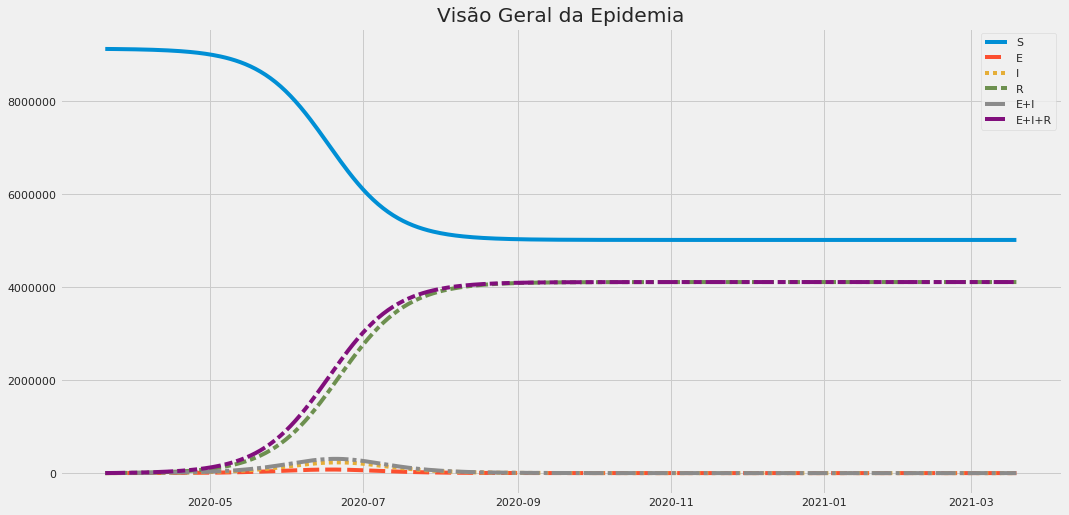

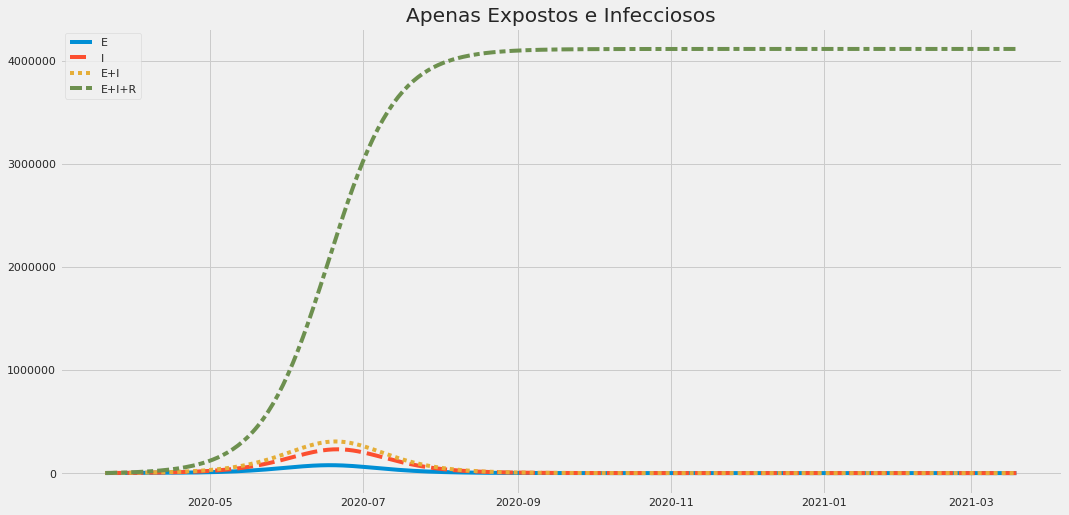

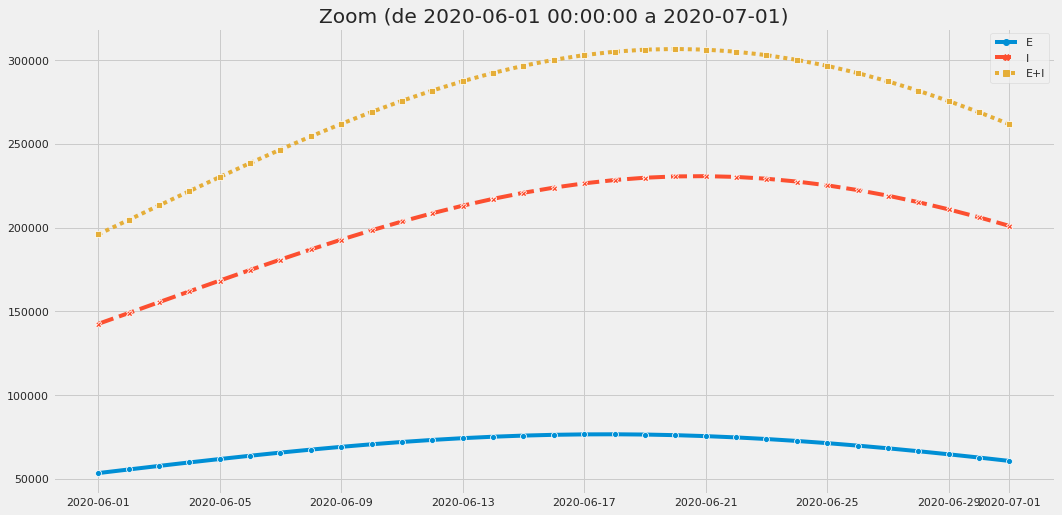

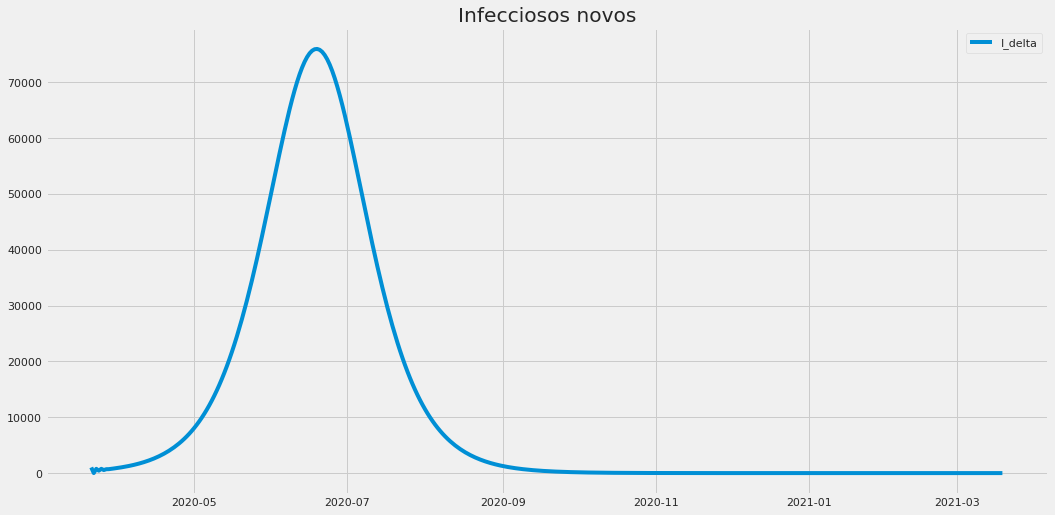

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

1.3236614391461448

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

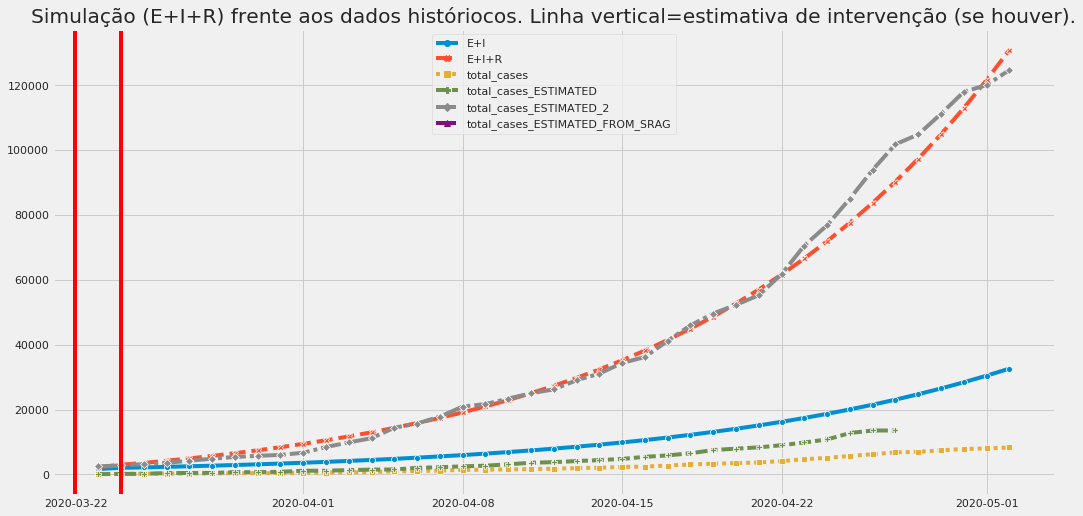

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

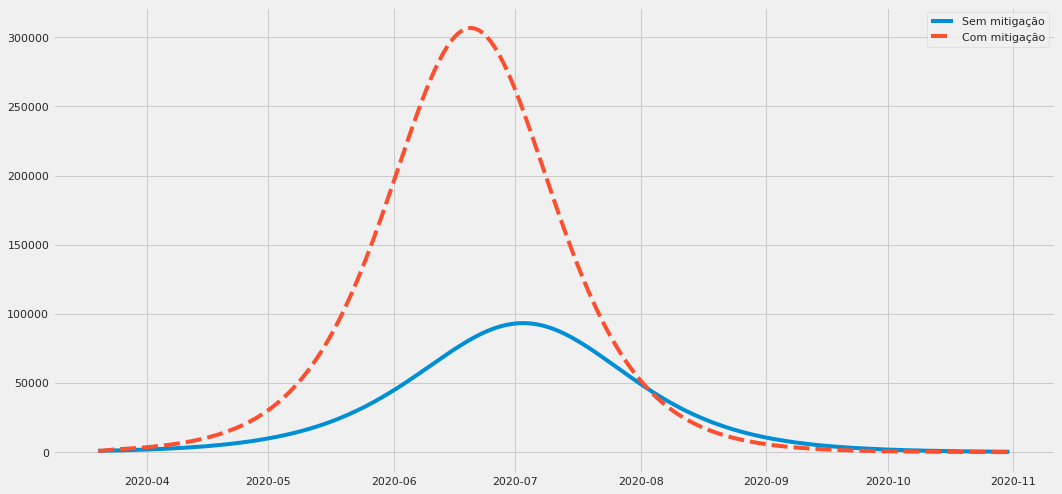

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

46

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.